# Trapezoidal extraction compare to box

## Imports

In [13]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Imports froom standard packages

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.sparse import identity
from astropy.io import fits
import numpy as np

# Imports for extraction

from extract.overlap import TrpzOverlap
from extract.utils import grid_from_map
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

# Local imports
from simulation_utils import load_simu, add_noise

In [8]:
from extract.utils import oversample_grid
from extract.overlap import fct_ones
from extract.regularisation import finite_first_d, finite_second_d, finite_zeroth_d

In [3]:
class TestExtractSingleOrd:
    
    def __init__(self, scidata, wave_map, spat_pro, f_th, grid_f_th, order,
                 factors=None, i_plot=True, n_os=1, tikho_kwargs=None, uncert=None, 
                 bin_limits=None, grid_trpz=None, wave_grid=None, wv_cols=None, name=None,
                 wv_range=None, **kwargs):

        self.f_th = f_th
        self.simu_grid = grid_f_th
        self.scidata = scidata
        
        if name is None:
            name = ''
        self.name = name
        
        if uncert is None:
            uncert = np.ones_like(scidata)
            self.noisy = False
        else:
            self.noisy = True
        self.uncert = uncert

        # Define wavelength grid
        if wave_grid is None:
            wave_grid, wv_cols = grid_from_map(wave_map, spat_pro, out_col=True)
            
        if wv_range is not None:
            idx = (wv_range[0] <= wave_grid)
            idx &= (wave_grid <= wv_range[1])
            wave_grid = wave_grid[idx]
            wv_cols = wv_cols[idx]

        # Define bins and grid for trpz extraction
        if bin_limits is None:
            lam_p, lam_m = get_lam_p_or_m(wave_grid)
            lam_p, lam_m = np.sort(lam_p), np.sort(lam_m)
            bin_limits = [lam_m, lam_p]

        if grid_trpz is None:
            grid_trpz = np.concatenate([bin_limits[0], [bin_limits[1][-1]]])
            grid_trpz = oversample_grid(grid_trpz, n_os)

        # Init extraction of a single order
        extra_trpz = TrpzOverlap([spat_pro], [wave_map], [fct_ones], [np.array([1])],
                     lam_grid=grid_trpz, orders=[order], **kwargs)

        # Extraction
        if factors is None:
            # Extract without tikhonov
            f_k = extra_trpz.extract(data=scidata, sig=uncert)
        else:
            # First search for best factor
            tikho_tests = extra_trpz.get_tikho_tests(factors, data=scidata,
                                                     sig=uncert, tikho_kwargs=tikho_kwargs)
            best_fac = extra_trpz.best_tikho_factor(tikho_tests, i_plot=i_plot)
            # Save these tests
            tikho_tests_saved = tikho_tests
            # Second search finer
            # Refine the grid (span 4 orders of magnitude).
            best_fac = np.log10(best_fac)
            factors = np.logspace(best_fac-2, best_fac+2, 20)

            # No need to specify `data` and `sig` again. 
            tests = extra_trpz.get_tikho_tests(factors, data=scidata,
                                               sig=uncert, tikho_kwargs=tikho_kwargs)
            best_fac = extra_trpz.best_tikho_factor(tests=tests, i_plot=i_plot)
            f_k = extra_trpz(data=scidata, tikhonov=True, factor=best_fac,
                             tikho_kwargs=tikho_kwargs)
            
            # Save Binned tikho tests
            idx = np.isfinite(f_k)
            tikho_tests_binned = {'f_bin': []}
            tikho_tests_binned['factors'] = tikho_tests_saved['factors']
            for i_sln, fac in enumerate(tikho_tests_saved['factors']):
                sln = np.nan * f_k
                sln[idx] = tikho_tests_saved['solution'][i_sln]
                _, sln_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=sln)
                tikho_tests_binned['f_bin'].append(sln_bin)
            self.tikho_tests_binned = tikho_tests_binned

        # Bin extracted spectrum
        bin_center, f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=f_k)

        # Binned theoretical 
        idx = (grid_f_th >= grid_trpz.min())  &  (grid_f_th <= grid_trpz.max())
        _, f_bin_th = extra_trpz.bin_to_pixel(grid_pix=bin_limits,
                                              f_k_c=f_th[idx],
                                              grid_f_k=grid_f_th[idx])
        # Rebuild detector
        rebuilt = extra_trpz.rebuild(f_k)
        
        # Theoretical photon noise
        phot_noise = extra_trpz.estim_noise()
        
        idx_spl = np.isfinite(phot_noise[1])
        noise_spl = interp1d(phot_noise[0][idx_spl], phot_noise[1][idx_spl],
                             kind='cubic', bounds_error=False, fill_value=np.nan)
        
        self.phot_noise = phot_noise
        self.phot_noise_spl = noise_spl

        self.f_bin_th = f_bin_th        
        self.f_k = f_k
        self.f_bin = f_bin
        self.bin_center = bin_center
        self.bin_limits = bin_limits
        self.grid_trpz = grid_trpz
        self.rebuilt = rebuilt
                                              
    def show_col_residuals(self, cols=None, fig=None, ax=None):
        
        scidata = self.scidata
        rebuilt = self.rebuilt
        uncert = self.uncert
        name = self.name
        
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(2, 1, sharex=True)
            else:
                ax = fig.axes
                
        if cols is None:
            cols = range(10, 20)
                
        residual = (rebuilt-scidata)/scidata*1e6
        for i_col in cols:
            ax[0].plot(residual[:,i_col], ".", label=i_col)
            ax[1].plot(((rebuilt-scidata)/uncert)[:,i_col], ".")
        ax[0].set_ylabel("Relative error [ppm]")
        ax[1].set_ylabel("Error [$\sigma$]")
        ax[0].set_title(name)
        
        return fig, ax
    
    def compare_binned(self, fig=None, ax=None, hist_kwargs=None, wv_range=None, f_bin=None):
        
        if f_bin is None:
            f_bin = self.f_bin
            
        f_bin_th = self.f_bin_th
        bin_center = self.bin_center
        name = self.name
        
        if wv_range is None:
            idx = slice(None)
        else:
            idx = (bin_center < wv_range[1])
            idx &= (wv_range[0] <= bin_center)
        f_bin_th = f_bin_th[idx]
        f_bin = f_bin[idx]
        bin_center = bin_center[idx]
        
        
        if ax is None:
            if fig is None:
                fig = plt.figure()
                # Upper left
                ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=3)
                # Lower left
                ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=3, sharex=ax1)
                # Lower right (histogram)
                ax3 = plt.subplot2grid((2, 4), (1, 3), sharey=ax2)
                ax3.yaxis.tick_right()
                ax = [ax1, ax2, ax3]
            else:
                ax = fig.axes
                
        if hist_kwargs is None:
            hist_kwargs = {}
        
        default_hist_kwargs = {'orientation': "horizontal",
                               'histtype': "step"}
        hist_kwargs = {**default_hist_kwargs, **hist_kwargs}
                
                
        rel_error = (f_bin-f_bin_th)/f_bin_th * 1e6
        
        
        ax[0].plot(bin_center, f_bin_th)
        ax[0].plot(bin_center, f_bin, "--")
        ax[1].plot(bin_center, rel_error, ".")
        
        ax[2].hist(rel_error, **hist_kwargs)
        
        if self.noisy:
            ax[1].plot(bin_center, self.phot_noise_spl(bin_center)*1e6, "--",
                       color='cyan', label='Photon noise')
            ax[1].plot(bin_center, -self.phot_noise_spl(bin_center)*1e6, "--",
                       color='cyan')
            ax[1].legend()
        

        ax[0].set_ylabel("Spectrum (binned)")
        ax[1].set_ylabel("Relative error [ppm]")
        ax[1].set_xlabel("Wavelength [microns]")
        ax[0].tick_params(labelbottom=False)
        ax[0].set_title(name)
        
        return fig, ax
     

    def compare_extracted(self, fig=None, ax=None):
        
        f_th = self.f_th
        f_k = self.f_k
        grid_trpz = self.grid_trpz
        simu_grid = self.simu_grid
        name = self.name
        
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(2, 1, sharex=True)
            else:
                ax = fig.axes
                
        f_th_spl = interp1d(simu_grid, f_th, kind='cubic',
                            bounds_error=False, fill_value=np.nan)
        f_th = f_th_spl(grid_trpz)
                
        ax[0].plot(grid_trpz, f_th)
        ax[0].plot(grid_trpz, f_k, "--")
        ax[1].plot(grid_trpz, (f_k-f_th)/f_th * 1e6, ".")

        ax[0].set_ylabel("Spectrum (f_k)")
        ax[1].set_ylabel("Relative error [ppm]")
        ax[1].set_xlabel("Wavelength [microns]")
        ax[0].set_title(name)
        
        return fig, ax
    
    def plot_spectra(self, fig=None, ax=None):
        
        f_th = self.f_th
        f_k = self.f_k
        f_bin_th = self.f_bin_th
        f_bin = self.f_bin
        bin_center = self.bin_center
        grid_trpz = self.grid_trpz
        simu_grid = self.simu_grid
        name = self.name
        
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(2, 1, sharex=True)
            else:
                ax = fig.axes
                
        ax[0].plot(simu_grid, f_th, label="Injected")
        ax[0].plot(grid_trpz, f_k, "--", label="Extracted")
        ax[1].plot(bin_center, f_bin_th)
        ax[1].plot(bin_center, f_bin, "--")

        ax[0].set_ylabel("Flux (f_k)")
        ax[1].set_ylabel("Integrated flux (f_binned)")
        ax[1].set_xlabel("Wavelength [microns]")
        ax[0].set_title(name)

        return fig, ax


class TestExtractFirstOrd(TestExtractSingleOrd):
    
    def __init__(self, wave_map, spat_pro, scidata=None, f_th=None, grid_f_th=None,
                 uncert=None, simu=None, thrpt=None, name=None,
                 factors=None, i_plot=True, n_os=1, tikho_kwargs=None,
                 bin_limits=None, grid_trpz=None, wave_grid=None, wv_cols=None, **kwargs):
        
        if thrpt is None:
            thrpt = ThroughputSOSS(1)
        
        if scidata is None:
            scidata = simu['data']

        if f_th is None:
            f_th = simu["f_c1"] * thrpt(simu['grid_c1'])

        if grid_f_th is None:
            grid_f_th = simu['grid_c1']
            
        order = 1
            
        args = (scidata, wave_map, spat_pro, f_th, grid_f_th, order)
        kwargs = {'uncert': uncert,
                  'factors': factors,
                  'i_plot': i_plot,
                  'n_os': n_os,
                  'tikho_kwargs': tikho_kwargs,
                  'bin_limits': bin_limits,
                  'grid_trpz': grid_trpz,
                  'wave_grid': wave_grid,
                  'wv_cols': wv_cols,
                  'name': name,
                  **kwargs}
        super().__init__(*args, **kwargs)


## Load ref files

In [4]:
tilted = False

In [5]:
DEFAULT_PATH = '../jwst-mtl/SOSS/extract/'
DEFAULT_REF_FILES = {'wv_1': 'Ref_files/wavelengths_m1.fits',
                     'wv_2': 'Ref_files/wavelengths_m2.fits',
                     'P_1': 'Ref_files/spat_profile_m1.fits',
                     'P_2': 'Ref_files/spat_profile_m2.fits'}

# Read relevant files
wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

if not tilted:
    # Remove the tilt from wv maps
    wv_1 = np.tile(wv_1[50,:], (256, 1))
    wv_2 = np.tile(wv_2[50,:], (256, 1))

## Load simu

In [92]:
# Load a simulation

if tilted:
    simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker.fits", noisy=False)
#     simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e-01.fits", order=1, noisy=False)
else:
    simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker_notilt.fits", noisy=False)
#     simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+01_no-tilt.fits", order=1, noisy=False)
scidata = simu["data"]

## Create an estimate (may be used for the tikhonov matrix)

In [496]:
def get_estimate_fct(simu_file, blurred=False, box_len=201, i_plot=False):

    simu = load_simu(simu_file)
    
    estimate_ord = {}

    for order in order_list:
        if blurred:
            flux_estimate = np.convolve(simu[f"f_c{order}"],
                                        np.ones(box_len)/box_len,
                                        mode='valid')
            idx_valid = slice(box_len//2,-1* box_len//2+1)
        else:
            idx_valid = slice(box_len//2,-1* box_len//2+1)
            flux_estimate = simu[f"f_c{order}"][idx_valid]

        estimate_ord[order] = interp1d(simu[f"grid_c{order}"][idx_valid],
                                       flux_estimate, kind="linear", 
                                       bounds_error=False,
                                       fill_value=np.nan)
        if i_plot:
            plt.plot(simu[f"grid_c{order}"], simu[f"f_c{order}"])


    idx_order1 = simu["grid_c1"] > np.max(simu["grid_c2"])
    comb_grid = np.concatenate([simu["grid_c2"], simu["grid_c1"][idx_order1]])
    estimate = [estimate_ord[order](comb_grid) for order in order_list]
    estimate = np.nanmean(estimate, axis=0)

    estim_spl = interp1d(comb_grid, estimate, kind="linear",
                         bounds_error=False, fill_value='extrapolate')

    if i_plot:
        plt.plot(comb_grid, estimate)

    return estim_spl

In [497]:
def get_tikho_matrix(grid, mode=None, estimate=None):
    
    if mode == 'zeroth':
        t_mat = finite_zeroth_d(grid)
    elif mode == 'first_d-wave':
         t_mat = finite_first_d(grid)
    elif mode == 'first_no-d-wave':
        t_mat = finite_first_d(np.arange(len(grid)))
    elif mode == 'second_d-wave':
        t_mat = finite_second_d(grid)
    elif mode == 'second_no-d-wave':
        t_mat = finite_second_d(np.arange(len(grid)))
    elif mode == 'quad_smooth_d-wave':
        t_mat = quadratic_smooth(grid)
    elif mode == 'quad_smooth_no-d-wave':
        t_mat = quadratic_smooth(np.arange(len(grid)))
    elif mode == 'lin_smooth_d-wave':
        t_mat = linear_smooth(grid)
    else:
        raise ValueError('Mode not valid')

    if estimate is not None:
    #     # Weights according to 'Thompson1989'
    #     tikho_factor_scale = np.power(estimate(grid), -1)
    #     tikho_factor_scale /= np.sum(tikho_factor_scale)

        # Weights according to 'kunasz1973'
        tikho_factor_scale = np.power(estimate(grid), -2)
        tikho_factor_scale /= np.sum(tikho_factor_scale)

#         # Artificially give more weights to red border
#         tikho_factor_scale[-4:] /= 100
#     #     tikho_factor_scale[:4] /= 1000

        if 'first' in mode:
            t_mat = diags(tikho_factor_scale[:-1]).dot(t_mat)
        elif ('second' in mode):
            t_mat = diags(tikho_factor_scale[1:-1]).dot(t_mat)
        else:
            t_mat = diags(tikho_factor_scale).dot(t_mat)
        
    
    return t_mat


In [94]:
spat_pros = [P1, P2]
wave_maps = [wv_1, wv_2]

# List of orders to consider in the extraction
order_list = [1, 2]

n_os = 5


#### Convolution kernels ####
WebbKer.file_frame = "spectral_kernel_matrix_os_{}_width_{}pixels_cut.fits"
WebbKer.path = ''
ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]# Map of expected noise (standard deviation).


### Convolution defaults ###
length_ker = 21*n_os + ((21*n_os)%2 == 0)
c_kwargs = [{'n_out': [5*n_os, 1*n_os], 'length':length_ker}]
c_kwargs.append({'n_out': [1*n_os, 5*n_os], 'length':length_ker})

In [97]:
from extract.utils import get_soss_grid, get_lam_p_or_m, grid_from_map

In [269]:
from classic import box_extract, get_box_weights, get_trace_center

In [348]:
from os import mkdir

In [464]:
def get_ref_files(tilted):

    DEFAULT_PATH = '../jwst-mtl/SOSS/extract/'
    DEFAULT_REF_FILES = {'wv_1': 'Ref_files/wavelengths_m1.fits',
                         'wv_2': 'Ref_files/wavelengths_m2.fits',
                         'P_1': 'Ref_files/spat_profile_m1.fits',
                         'P_2': 'Ref_files/spat_profile_m2.fits'}

    # Read relevant files
    wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
    wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
    P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
    P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

    # Convert to float (fits precision is 1e-8)
    wv_1 = wv_1.astype(float)
    wv_2 = wv_2.astype(float)
    P1 = P1.astype(float)
    P2 = P2.astype(float)

    if not tilted:
        # Remove the tilt from wv maps
        wv_1 = np.tile(wv_1[50,:], (256, 1))
        wv_2 = np.tile(wv_2[50,:], (256, 1))
        
    return [P1, P2], [wv_1, wv_2]


class TestExtractContOrd:
    
    def __init__(self, simu_file, tikho_kwargs, factors, tilted=False, noisy=False, n_os=2,
                 wave_grid=None, wv_range=None, bin_limits=None, grid_trpz=None, i_plot=True,
                 box_width=30, name=None):
        
        if name is None:
            name = ''
    
        # Read ref files
        spat_pros, wave_maps = get_ref_files(tilted)
        
        # Get simu
        simu = load_simu(simu_file, noisy=noisy)
        scidata = simu['data']
        mask_scidata = ~np.isfinite(scidata)
        
        # List of orders to consider in the extraction
        order_list = [1, 2]

        #### Convolution kernels ####
        WebbKer.file_frame = "spectral_kernel_matrix_os_{}_width_{}pixels_cut.fits"
        WebbKer.path = ''
        ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

        #### Throughputs ####
        thrpt_list = [ThroughputSOSS(order) for order in order_list] # Map of expected noise (standard deviation).
            
        
        # Special default args for the connvolution matrix
        length_ker = 21*n_os + ((21*n_os)%2 == 0)
        c_kwargs = [{'n_out': [5*n_os, 1*n_os], 'length':length_ker}]
        c_kwargs.append({'n_out': [1*n_os, 5*n_os], 'length':length_ker})
        
        # Noise estimate to weigh the pixels.
        # Poisson noise + background noise.
        if noisy:
            bkgd_noise = 20.  # In counts?
            uncert = np.sqrt(scidata + bkgd_noise**2)
        else:
            uncert = None

        # Define wavelength grid
        if wave_grid is None:
            wave_grid = get_soss_grid(spat_pros, wave_maps, n_os=1)

        if wv_range is not None:
            idx = (wv_range[0] <= wave_grid)
            idx &= (wave_grid <= wv_range[1])
            wave_grid = wave_grid[idx]

        # Define bins and grid for trpz extraction
        if bin_limits is None:
            lam_p, lam_m = get_lam_p_or_m(wave_grid)
            lam_p, lam_m = np.sort(lam_p), np.sort(lam_m)
            bin_limits = [lam_m, lam_p]

        if grid_trpz is None:
            grid_trpz = np.concatenate([bin_limits[0], [bin_limits[1][-1]]])
            grid_trpz = oversample_grid(grid_trpz, n_os)

        # Define bin limits order by order
        bin_lim_ord = {}
        for i_ord, order in enumerate(order_list):
            wv_grid, _ = grid_from_map(wave_maps[i_ord], spat_pros[i_ord], out_col=True)

            if wv_range is not None:
                idx = (wv_range[0] <= wv_grid)
                idx &= (wv_grid <= wv_range[1])
                wv_grid = wv_grid[idx]

            # Define bins and grid for trpz extraction
            lam_p, lam_m = get_lam_p_or_m(wv_grid)
            lam_p, lam_m = np.sort(lam_p), np.sort(lam_m)
            bin_lim_ord[order] = [lam_m, lam_p]


        # Init extraction
        extra_trpz = TrpzOverlap(spat_pros, wave_maps, thrpt_list, ker_list, sig=uncert,
                     lam_grid=grid_trpz, orders=order_list, c_kwargs=c_kwargs, mask=mask_scidata)

        # First search for best factor
        tikho_tests = extra_trpz.get_tikho_tests(factors, data=scidata, tikho_kwargs=tikho_kwargs)
        best_fac = extra_trpz.best_tikho_factor(tikho_tests, i_plot=i_plot)

        # Second search finer
        # Refine the grid (span 4 orders of magnitude).
        best_fac = np.log10(best_fac)
        factors = np.logspace(best_fac-2, best_fac+2, 20)

        # No need to specify `data` and `sig` again. 
        tikho_tests = extra_trpz.get_tikho_tests(factors, data=scidata, tikho_kwargs=tikho_kwargs)
        best_fac = extra_trpz.best_tikho_factor(tests=tikho_tests, i_plot=i_plot)
        # Save these tests
        tikho_tests_saved = tikho_tests
        
        # Re-extract with best factor
        f_k = extra_trpz(data=scidata, tikhonov=True, factor=best_fac,
                         tikho_kwargs=tikho_kwargs)
        
        # Save Binned tikho tests
        idx = np.isfinite(f_k)
        tikho_tests_binned = {'f_bin': []}
        tikho_tests_binned['factors'] = tikho_tests_saved['factors']
        for i_sln, fac in enumerate(tikho_tests_saved['factors']):
            sln = np.nan * f_k
            sln[idx] = tikho_tests_saved['solution'][i_sln]
            _, sln_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=sln)
            tikho_tests_binned['f_bin'].append(sln_bin)
        self.tikho_tests_binned = tikho_tests_binned        
        
        # Bin for each orders
        f_bin_th = {}
        f_bin = {}
        grid_bin = {}
        tikho_tests_binned = {}

        for i_ord, order in enumerate(order_list):

            # Bin extracted spectra
            grid_bin[order], f_bin[order] = extra_trpz.bin_to_pixel(grid_pix=bin_lim_ord[order],
                                                                    f_k=f_k, i_ord=i_ord)

            # Get theoretical spectra
            grid_f_th = simu[f'grid_c{order}']
            f_th = simu[f'f_c{order}']
            # Binned theoretical 
            idx = (grid_f_th >= grid_trpz.min())  &  (grid_f_th <= grid_trpz.max())
            _, f_bin_th[order] = extra_trpz.bin_to_pixel(grid_pix=bin_lim_ord[order],
                                                  f_k_c=f_th[idx],
                                                  grid_f_k=grid_f_th[idx], i_ord=i_ord)
            
            # Save Binned tikho tests
            idx = np.isfinite(f_k)
            tikho_tests_binned[order] = {'f_bin': []}
            tikho_tests_binned[order]['factors'] = tikho_tests_saved['factors']
            for i_sln, fac in enumerate(tikho_tests_saved['factors']):
                sln = np.nan * f_k
                sln[idx] = tikho_tests_saved['solution'][i_sln]
                _, sln_bin = extra_trpz.bin_to_pixel(grid_pix=bin_lim_ord[order],
                                                     f_k=sln, i_ord=i_ord)
                tikho_tests_binned[order]['f_bin'].append(sln_bin)
                
        self.tikho_tests_binned = tikho_tests_binned
        self.f_bin_th = f_bin_th
        self.f_bin = f_bin
        self.grid_bin = grid_bin
        
        # Rebuild orders
        rebuilt_ord = {1:extra_trpz.rebuild(f_k, orders=[0]),
                       2:extra_trpz.rebuild(f_k, orders=[1])}

        # Decontaminate
        decont_ord = {1: scidata - rebuilt_ord[2],
                      2: scidata - rebuilt_ord[1]}
        
        # Load single ord simulations for comparison
        data_ord = {}
        for order in order_list:

            simu_ord = load_simu(simu_file, order=order, noisy=noisy)
            data_ord[order] = simu_ord["data"]
    
        # Extract with a box extraction order by order
        f_box_decont = {}
        f_box_th = {}
        f_box_cont = {}
        cols = {}
        for i_ord, order in enumerate(order_list):
            cols[order], centroid = get_trace_center(spat_pros[i_ord])
            box_weights = get_box_weights(cols[order], centroid, box_width, P1.shape)

            _, f_box_decont[order] = box_extract(decont_ord[order], box_weights,
                                                    mask=~np.isfinite(decont_ord[order]))
            _, f_box_th[order] = box_extract(data_ord[order], box_weights,
                                             mask=~np.isfinite(data_ord[order]))
            _, f_box_cont[order] = box_extract(scidata, box_weights,
                                                  mask=~np.isfinite(scidata))
            
        self.f_box_decont = f_box_decont
        self.f_box_th = f_box_th
        self.f_box_cont = f_box_cont
        self.cols = cols
        
        
        name = name + f'_n_os={n_os}_box={box_width}pix'
        if tilted:
            name = name + '_tilted'
        else:
            name = name + '_not-tilted'
            
        if noisy:
            name = name + '_noisy'
        else:
            name = name + '_noiseless'

        self.name = name
        self.noisy = noisy
        
    def compare_binned_ord(self, fig=None, ax=None, hist_kwargs=None,
                           wv_range=None, f_bin=None, order=1):
        
        if f_bin is None:
            f_bin = self.f_bin[order]
            
        f_bin_th = self.f_bin_th[order]
        bin_center = self.grid_bin[order]
        name = self.name
        
        if wv_range is None:
            idx = slice(None)
        else:
            idx = (bin_center < wv_range[1])
            idx &= (wv_range[0] <= bin_center)
        f_bin_th = f_bin_th[idx]
        f_bin = f_bin[idx]
        bin_center = bin_center[idx]
        
        
        if ax is None:
            if fig is None:
                fig = plt.figure(figsize=(9, 5))
                # Upper left
                ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=3)
                # Lower left
                ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=3, sharex=ax1)
                # Lower right (histogram)
                ax3 = plt.subplot2grid((2, 4), (1, 3), sharey=ax2)
                ax3.yaxis.tick_right()
                ax = [ax1, ax2, ax3]
            else:
                ax = fig.axes
                
        if hist_kwargs is None:
            hist_kwargs = {}
        
        default_hist_kwargs = {'orientation': "horizontal",
                               'histtype': "step"}
        hist_kwargs = {**default_hist_kwargs, **hist_kwargs}
                
                
        rel_error = (f_bin-f_bin_th)/f_bin_th * 1e6
        
        
        ax[0].plot(bin_center, f_bin_th)
        ax[0].plot(bin_center, f_bin, "--")
        ax[1].plot(bin_center, rel_error, ".")
        
        ax[2].hist(rel_error, **hist_kwargs)
        
#         if self.noisy:
#             ax[1].plot(bin_center, self.phot_noise_spl(bin_center)*1e6, "--",
#                        color='cyan', label='Photon noise')
#             ax[1].plot(bin_center, -self.phot_noise_spl(bin_center)*1e6, "--",
#                        color='cyan')
#             ax[1].legend()
        

        ax[0].set_ylabel("Spectrum (binned)")
        ax[1].set_ylabel("Relative error [ppm]")
        ax[1].set_xlabel("Wavelength [microns]")
        ax[0].tick_params(labelbottom=False)
        fig.suptitle(name)
        ax[0].set_title(f'Order {order}', loc='right', fontsize='medium')
        
        return fig, ax

    def compare_binned(self, fig=None, ax=None, f_bin=None):
        
        if f_bin is None:
            f_bin = self.f_bin
            
        f_bin_th = self.f_bin_th
        grid_bin = self.grid_bin
        
        name = self.name
        
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(5, 1, sharex=True, figsize=(9, 11))
            else:
                ax = fig.axes

        for order in order_list:
            ax[0].plot(grid_bin[order], f_bin[order])
            ax[0].plot(grid_bin[order], f_bin_th[order], "--")

            err_rel = (f_bin[order] - f_bin_th[order])/f_bin_th[order] * 1e6

            ax[order].plot(grid_bin[order], err_rel, ".")

            err_abs = (f_bin[order] - f_bin_th[order])
            ax[order+2].plot(grid_bin[order], err_abs, ".")
            
        fig.suptitle(name)
        ax[0].set_ylabel("Spectrum (binned)")
        ax[1].set_ylabel("Rel error [ppm]")
        ax[2].set_ylabel("Rel error [ppm]")
        ax[3].set_ylabel("Abs error")
        ax[4].set_ylabel("Abs error")
        ax[4].set_xlabel("Wavelength [microns]")
        
        ax[1].set_title("Order 1")
        ax[2].set_title("Order 2")
        ax[3].set_title("Order 1")
        ax[4].set_title("Order 2")
            
        return fig, ax
        

    def plot_contamination_box(self, order=1, fig=None, ax=None):

        f_box = self.f_box_th[order]
        f_box_cont = self.f_box_cont[order]
        f_box_decont = self.f_box_decont[order]

        name = f'order={order}, ' + self.name

        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(4, 1, sharex=True, figsize=(9, 11))
            else:
                ax = fig.axes

        y_plot = (f_box - f_box_cont) / f_box
        idx_cont = np.abs(y_plot) > 1e-8
        x_plot = cols[idx_cont]
        
        ax[0].plot(x_plot, f_box_cont[idx_cont], label='Contaminated')
        ax[0].plot(x_plot, f_box[idx_cont], label='Injected')
        ax[0].plot(x_plot, f_box_decont[idx_cont], '--', label='Decontaminated')
        ax[0].legend()
        ax[1].plot(x_plot, (y_plot * 1e6)[idx_cont], ".")
        ax[2].plot(x_plot, ((f_box-f_box_decont)/f_box*1e6)[idx_cont], ".")
        ax[3].plot(x_plot, ((f_box-f_box_decont)/np.abs(f_box-f_box_cont)*100)[idx_cont], ".")

        ax[1].set_ylabel('Level [ppm]')
        ax[2].set_ylabel('Level [ppm]')
        ax[3].set_ylabel('Relative [%]')
        ax[3].set_xlabel('Pixel columns')

        ax[1].set_title('Contaminated', loc='right', fontsize='medium')
        ax[2].set_title('Decontaminated', loc='right', fontsize='medium')
        ax[3].set_title('Decontaminated / contaminated', loc='right', fontsize='medium')

        fig.suptitle(name)
        
        return fig, ax

<IPython.core.display.Javascript object>


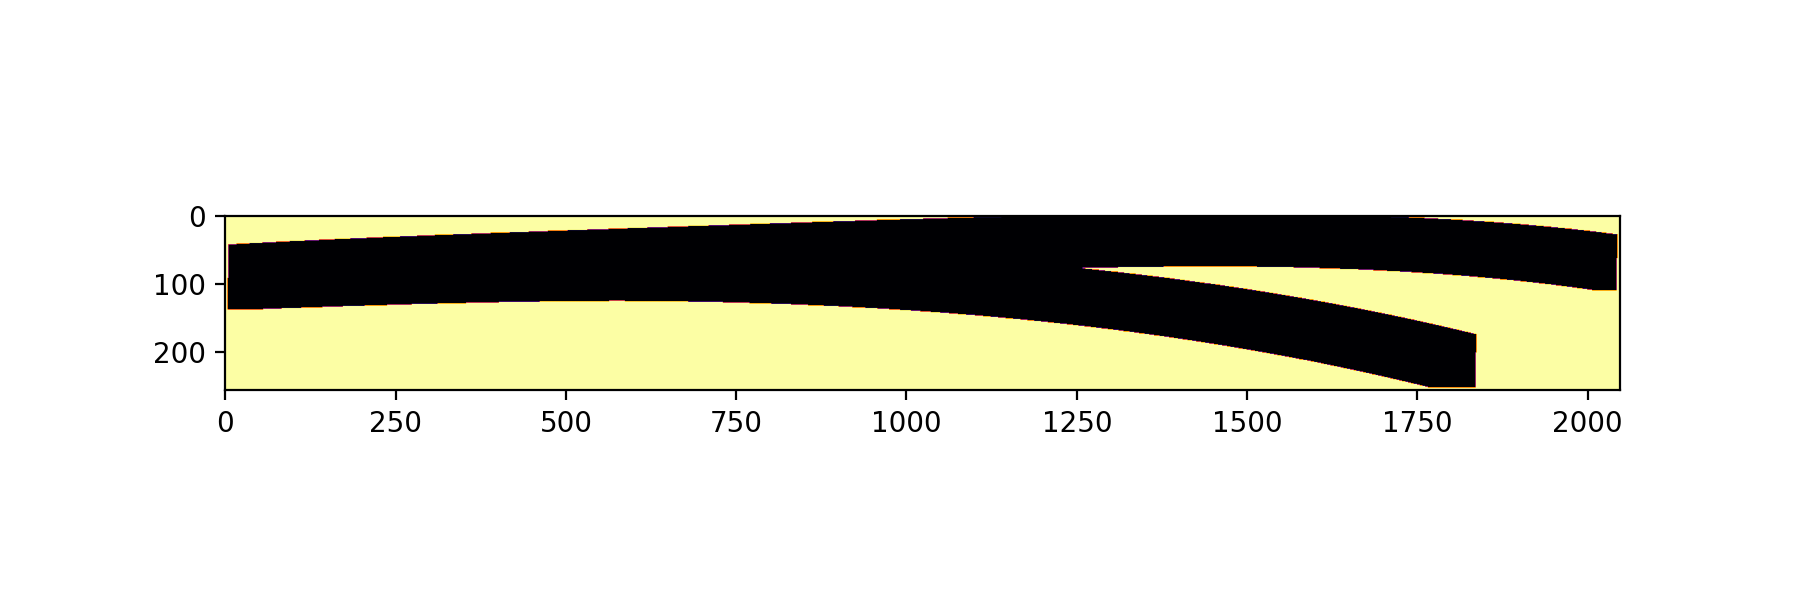

In [463]:
plt.imshow(np.isnan(load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker.fits",noisy=False)['data']))

In [502]:
mode = 'first_d-wave'
teff = '9000K'
estimate = True

factors = np.logspace(-25, -5, 15)

kwargs = {}
kwargs['noisy'] = False
kwargs['tilted'] = True
kwargs['n_os'] = 5
kwargs['box_width'] = 30
kwargs['name'] = teff + '_' + mode

if tilted:
    if teff == '9000K':
        simu_file = "../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker.fits"
    elif teff == '2300K':
        simu_file = "../Simulations/phoenix_teff_02300_scale_1.0e-01.fits"
    else:
        raise ValueError('Badname')
else:
    if teff == '9000K':
        simu_file = "../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker_notilt.fits"
    elif teff == '2300K':
        simu_file = "../Simulations/phoenix_teff_02300_scale_1.0e+01_no-tilt.fits"
    else:
        raise ValueError('Badname')
        
if estimate:
    estim_fct = get_estimate_fct(simu_file)
    kwargs['name'] += '_estim'
else:
    estim_fct = None
        
tikho_kwargs = {"t_mat":lambda x:get_tikho_matrix(x, mode=mode, estimate=estim_fct)}

test_contaminated = TestExtractContOrd(simu_file, tikho_kwargs, factors, **kwargs)

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


NameError: name 'diags' is not defined

In [500]:
path_fig = 'Tikho_decont/' + test_contaminated.name

In [501]:
path_fig

'Tikho_decont/9000K_first_d-wave_n_os=5_box=30pix_tilted_noiseless'

In [470]:
mkdir(path_fig)

<IPython.core.display.Javascript object>


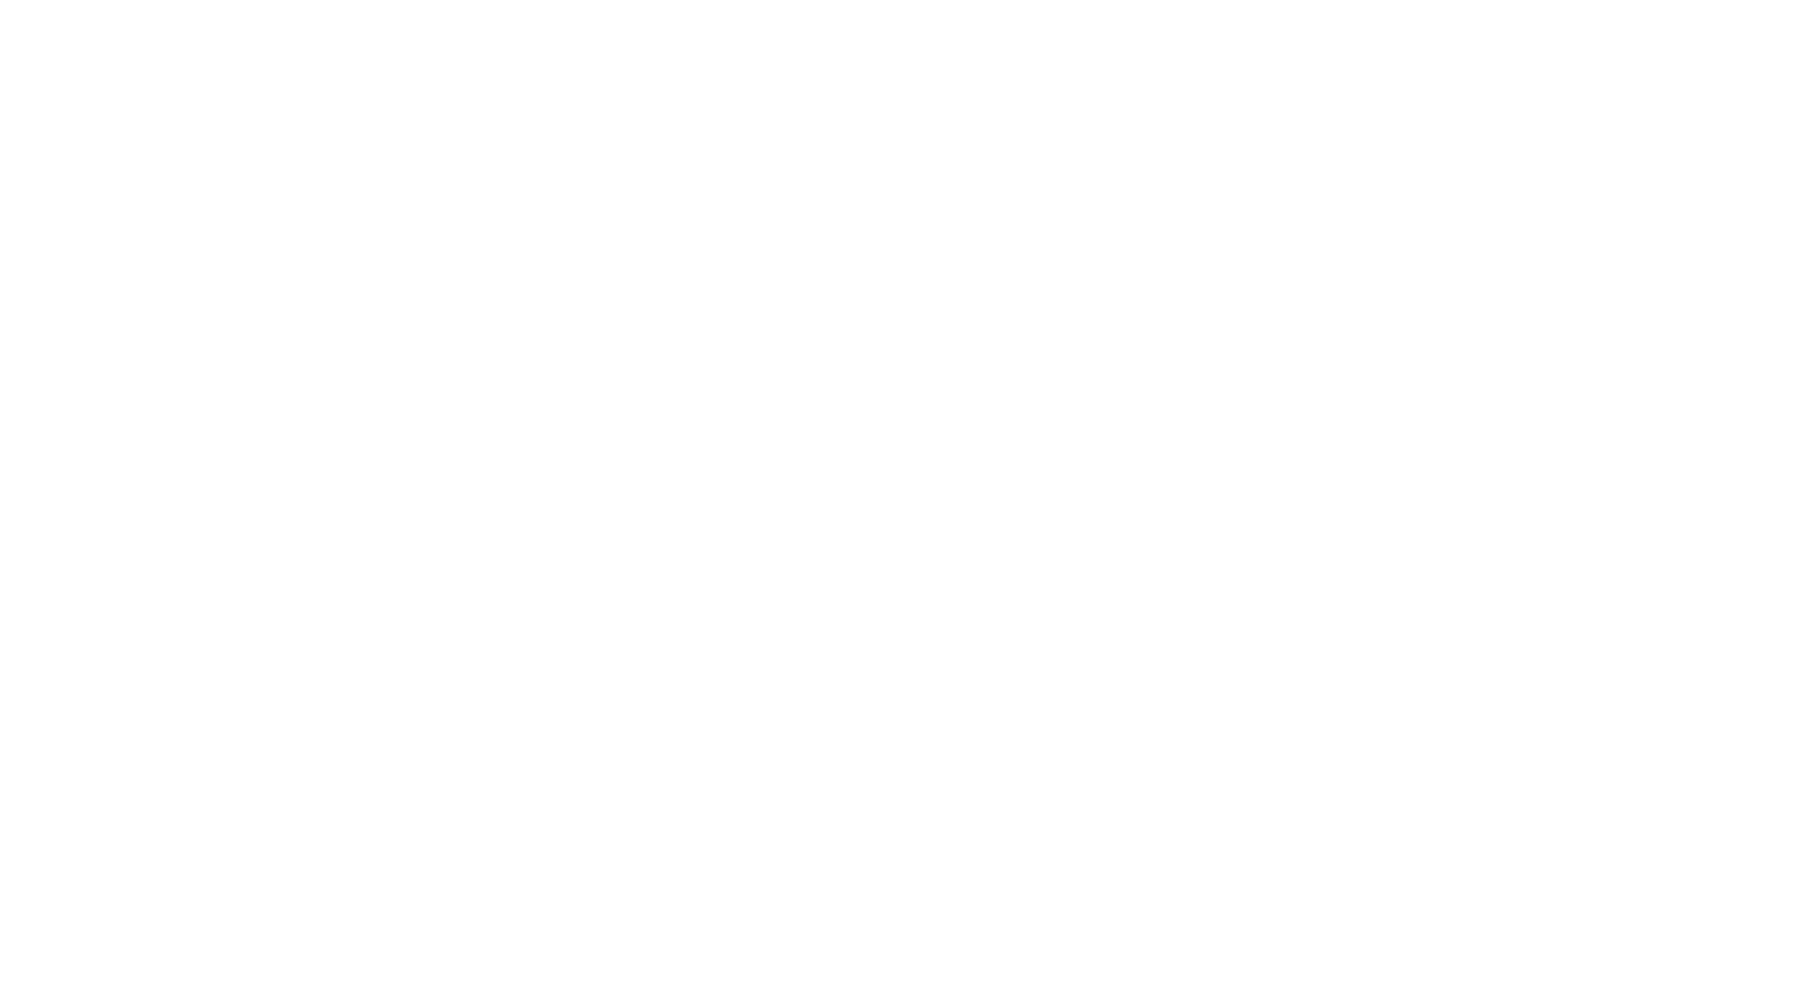

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


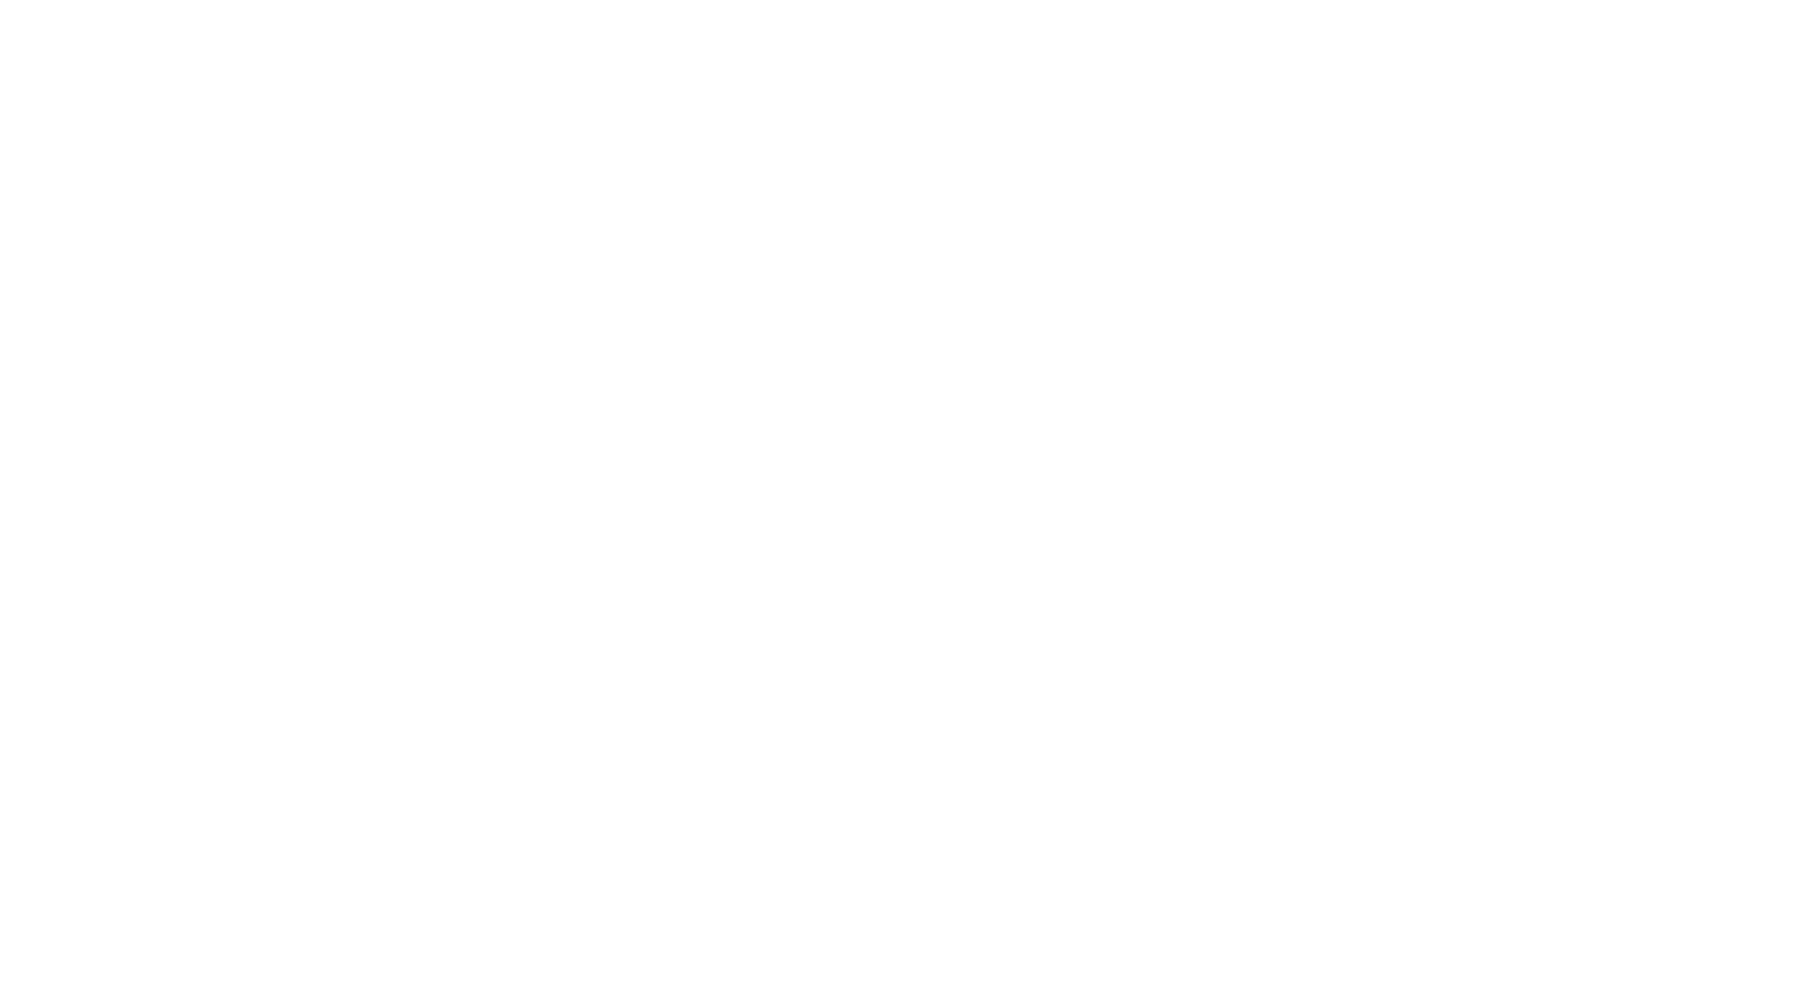

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [471]:
fig, ax = test_contaminated.compare_binned_ord(order=1)#, wv_range=[1.05, 2.3])
fig.savefig(path_fig + '/compare_binned_ord_1')
plt.close()

fig, ax = test_contaminated.compare_binned_ord(order=2)
fig.savefig(path_fig + '/compare_binned_ord_2')
plt.close()

<IPython.core.display.Javascript object>


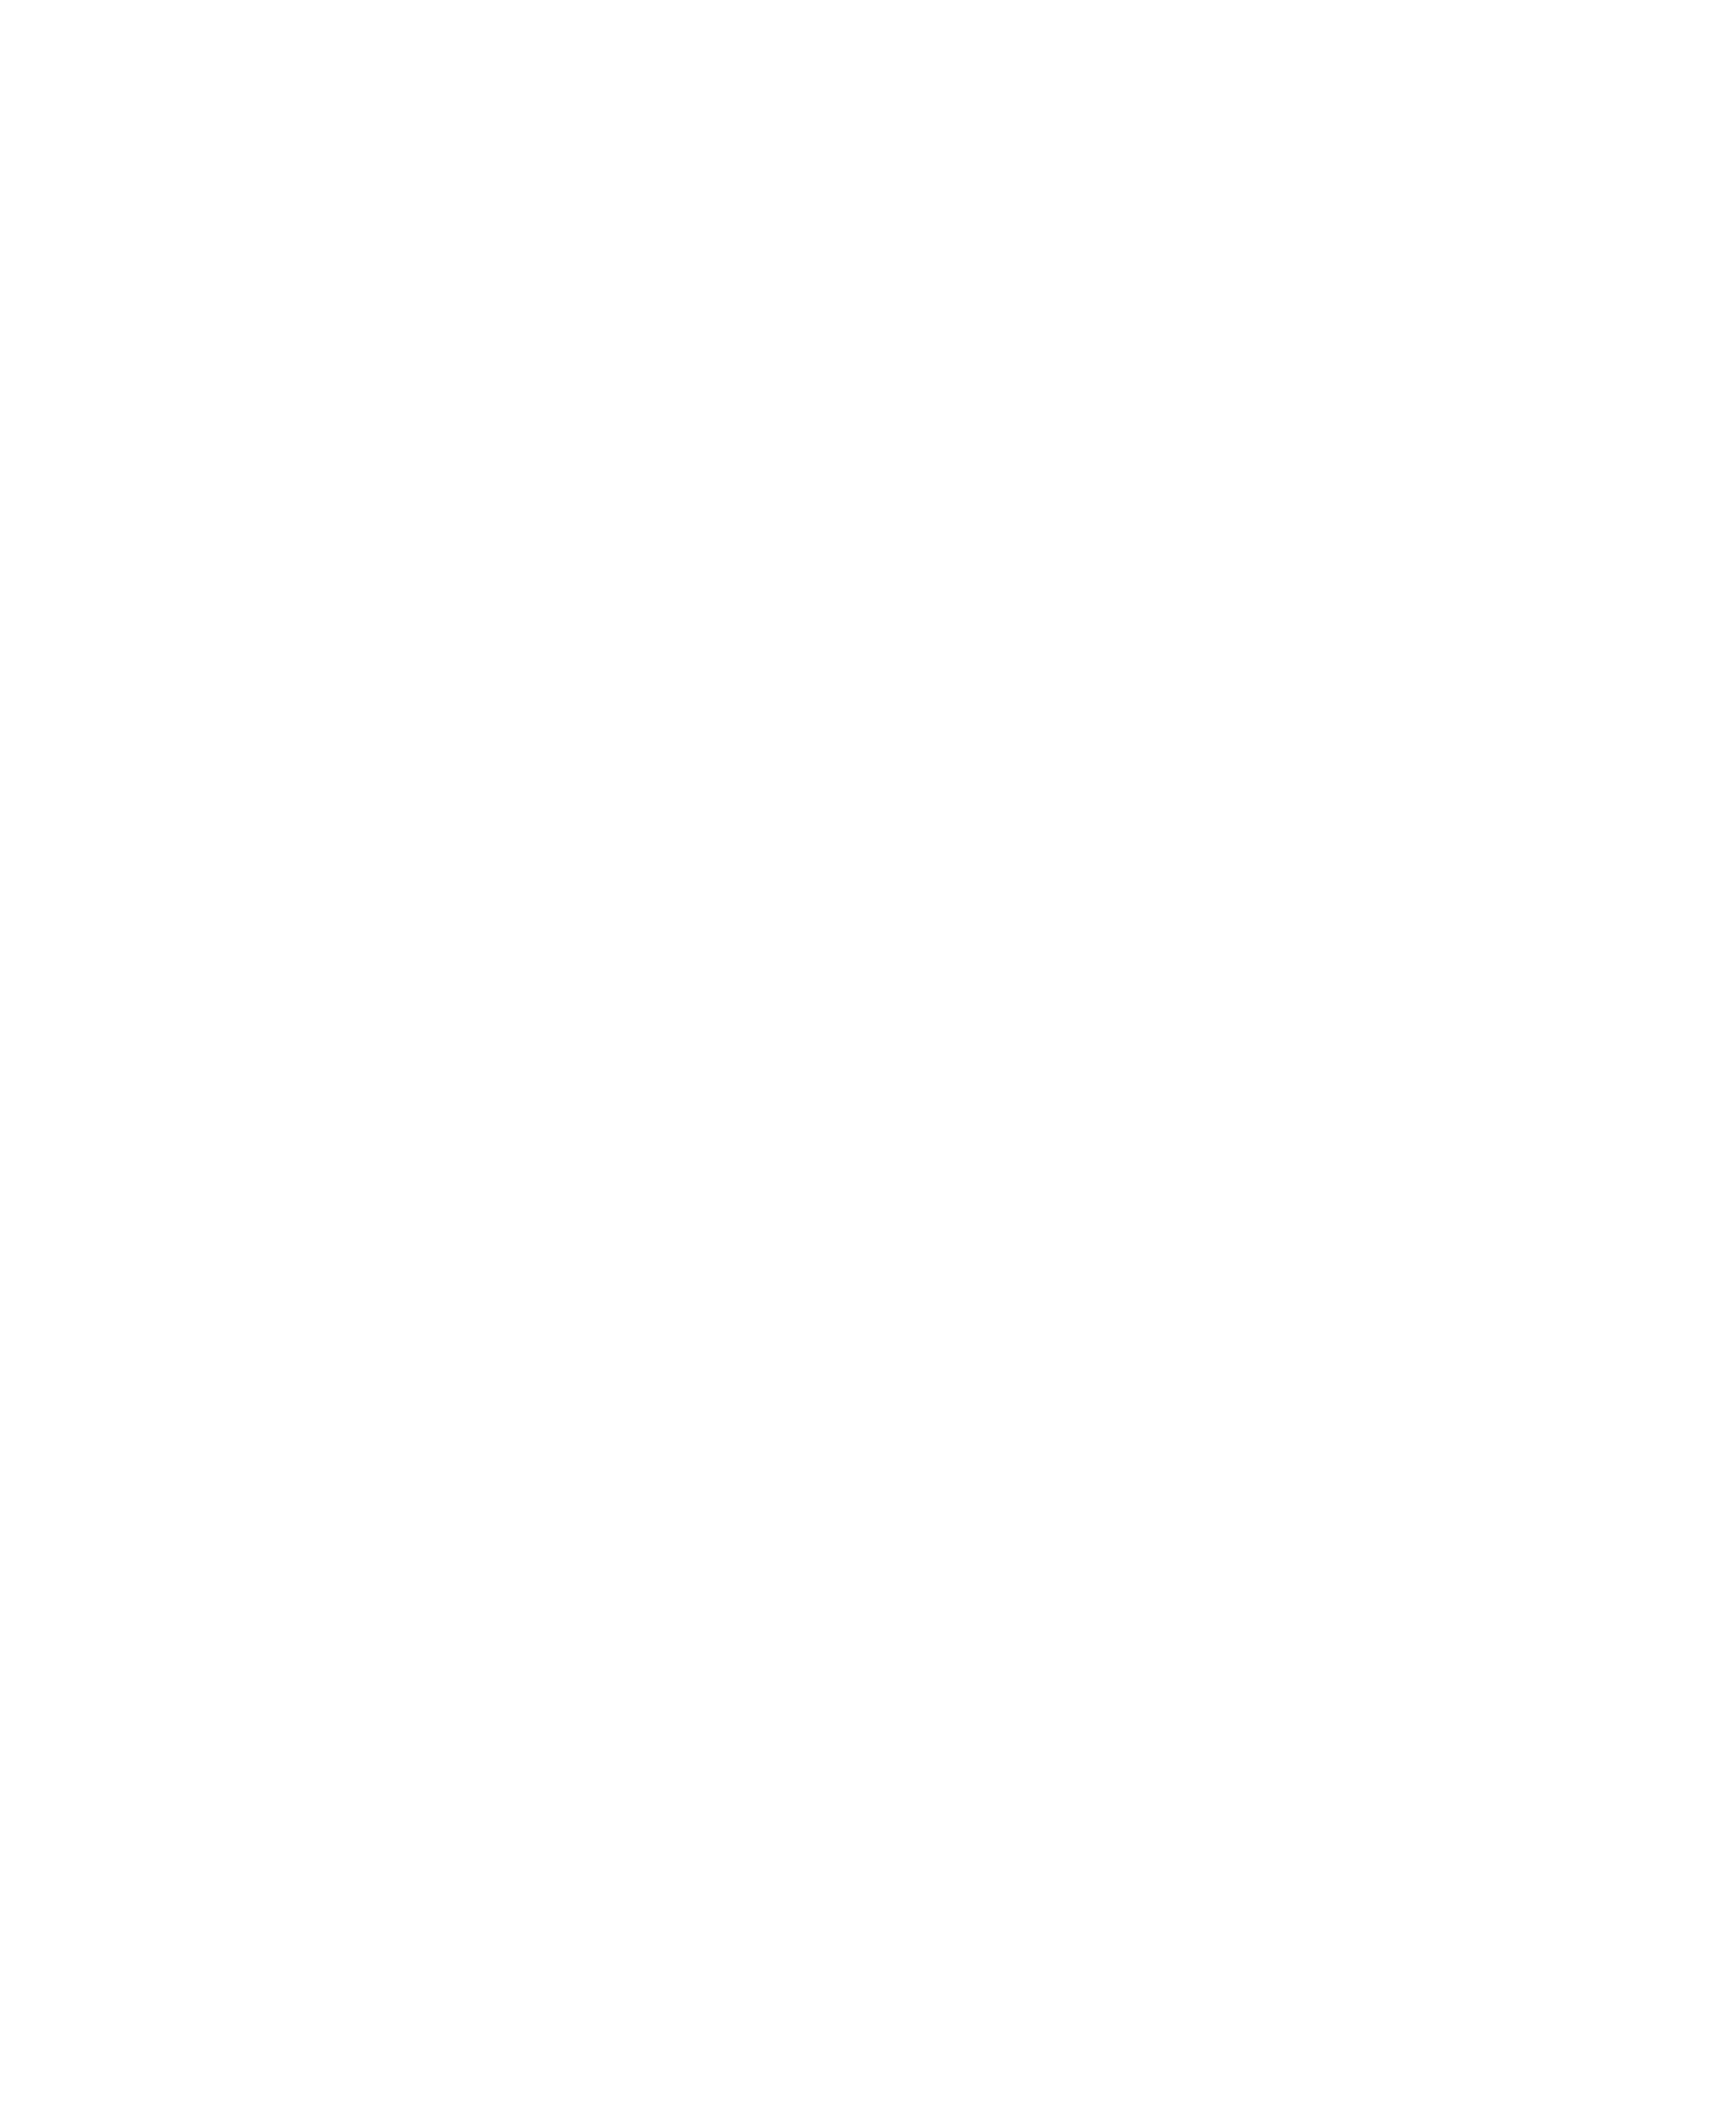

In [472]:
fig, ax = test_contaminated.compare_binned()
fig.savefig(path_fig + '/compare_binned')
plt.close()

<IPython.core.display.Javascript object>


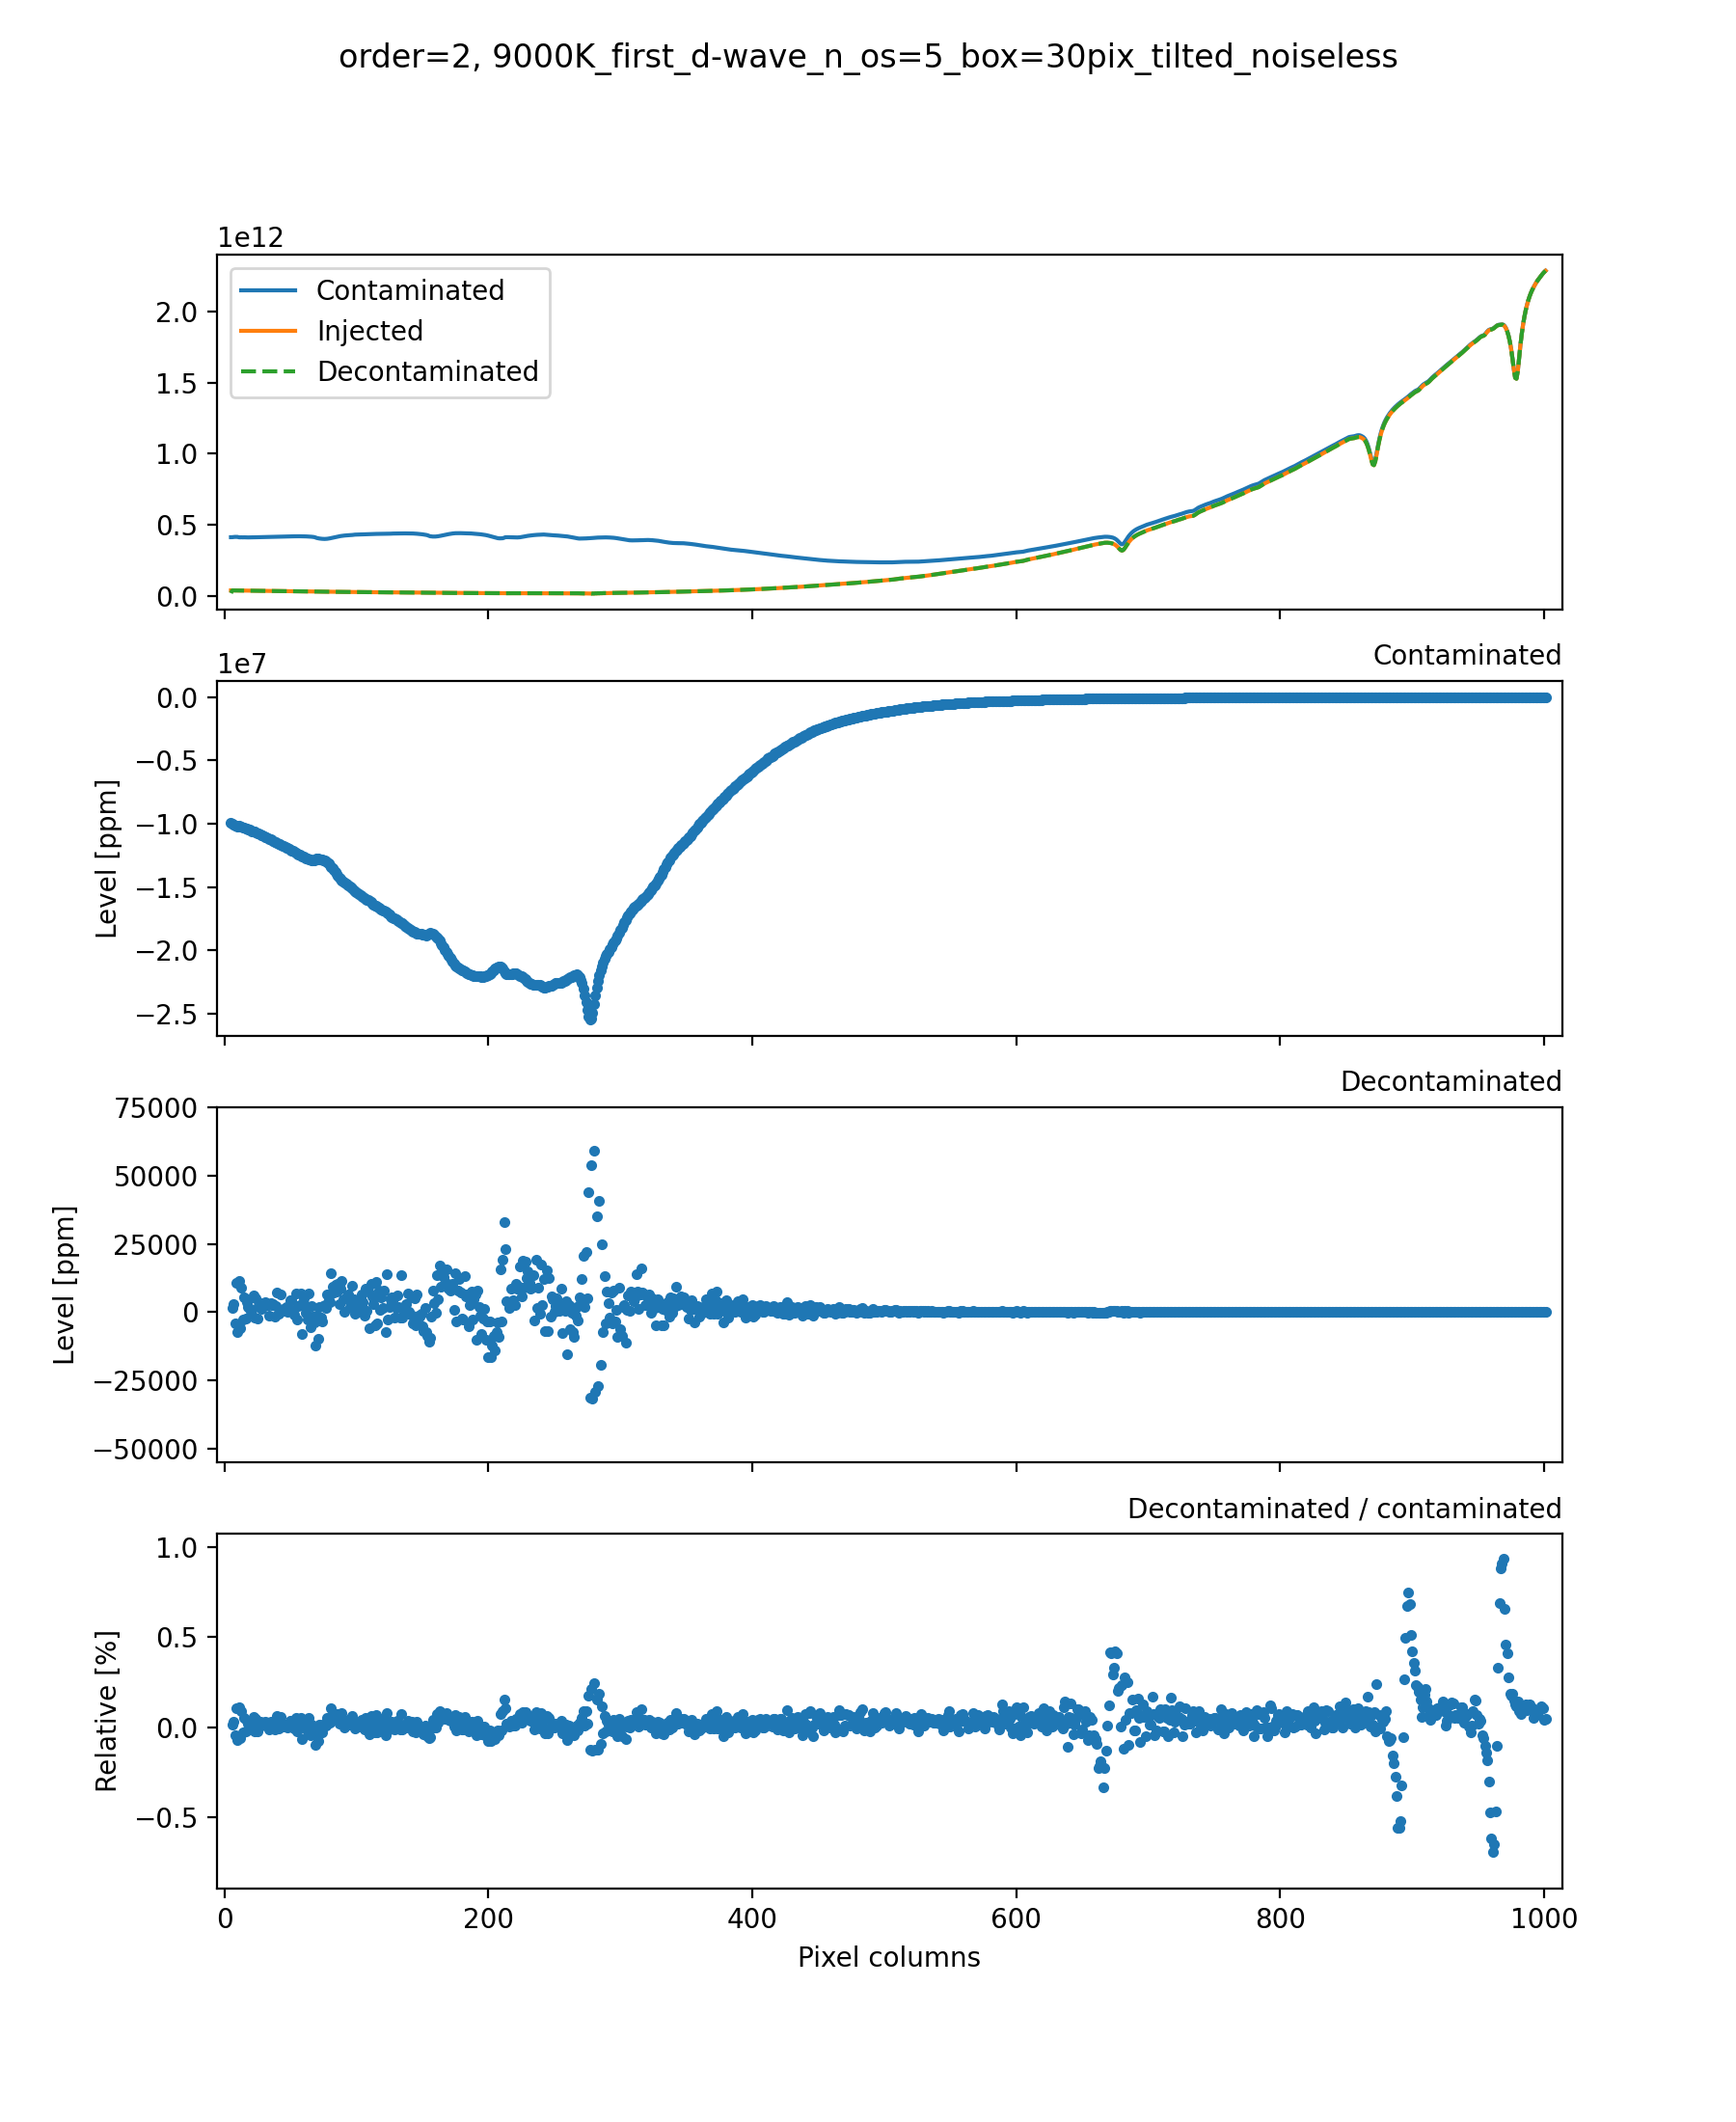

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:353: RuntimeWarning: invalid value encountered in true_divide
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:354: RuntimeWarning: invalid value encountered in greater
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:362: RuntimeWarning: invalid value encountered in true_divide
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:363: RuntimeWarning: divide by zero encountered in true_divide
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:363: RuntimeWarning: invalid value encountered in true_divide


In [486]:
fig, ax = test_contaminated.plot_contamination_box(order=1)
fig.savefig(path_fig + '/box_cont_ord_1')
plt.close()

fig, ax = test_contaminated.plot_contamination_box(order=2)
fig.savefig(path_fig + '/box_cont_ord_2')
plt.close()

In [487]:
# fig.savefig(path_fig + '/box_cont_ord_2')

<IPython.core.display.Javascript object>


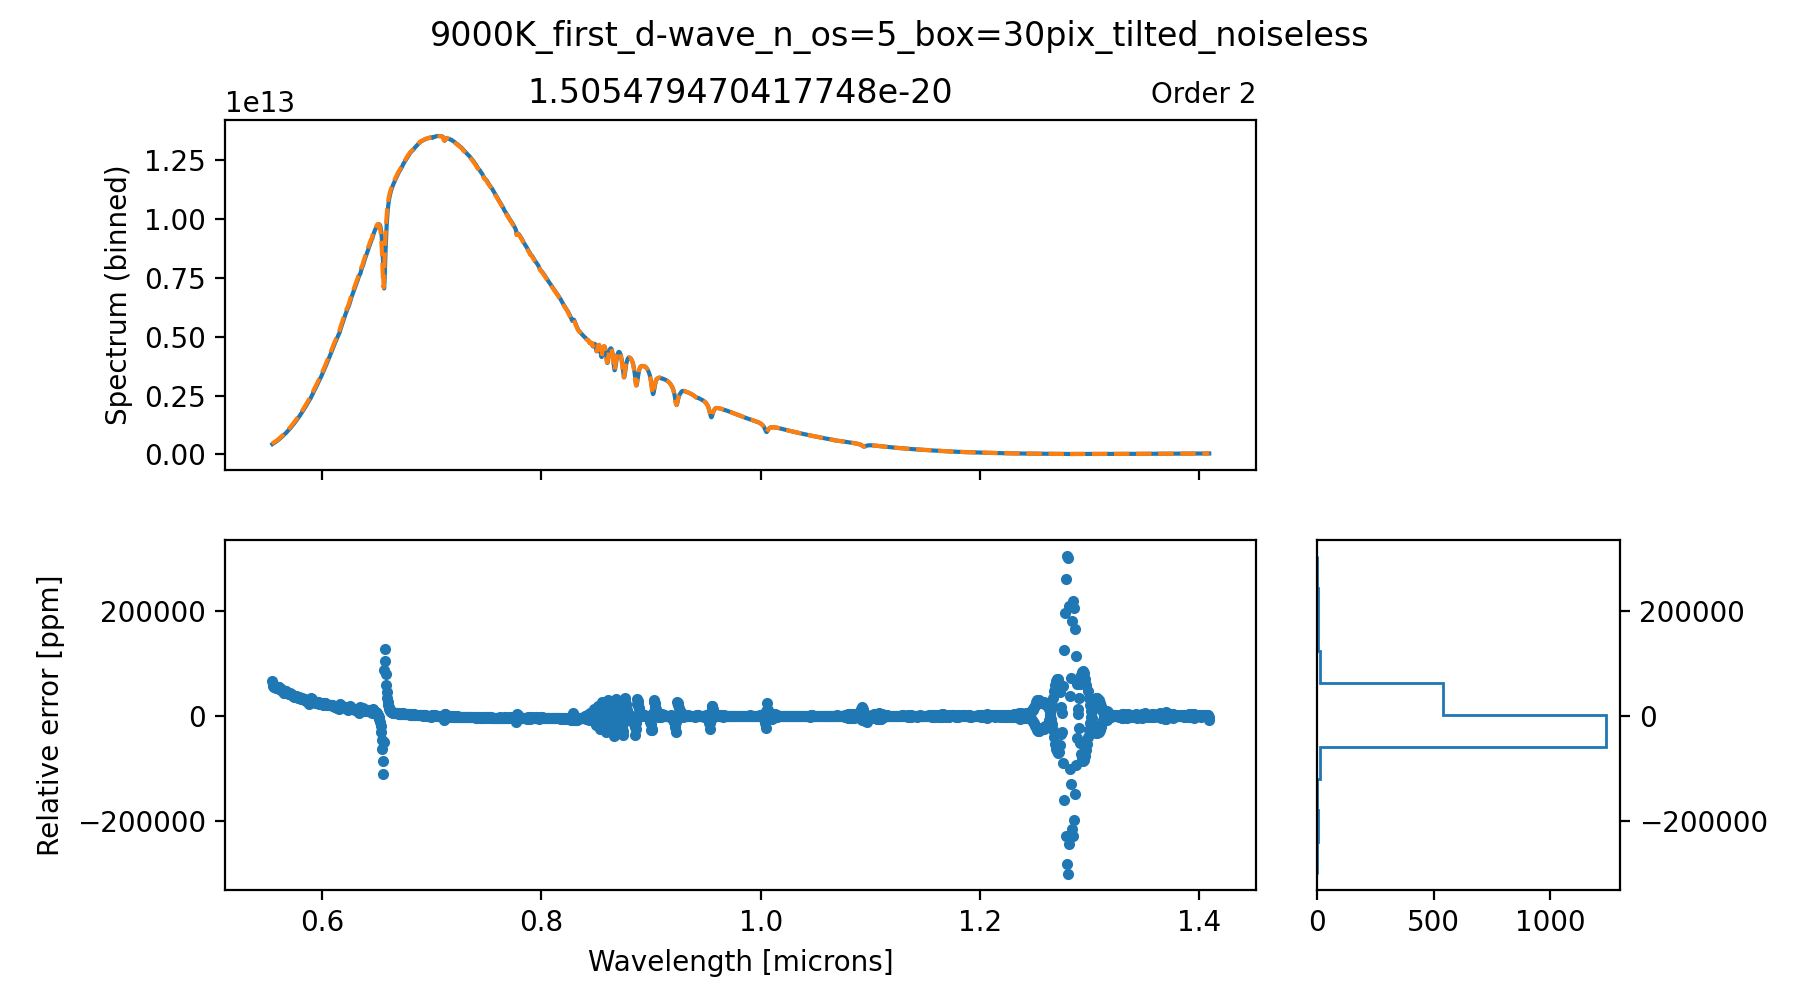

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


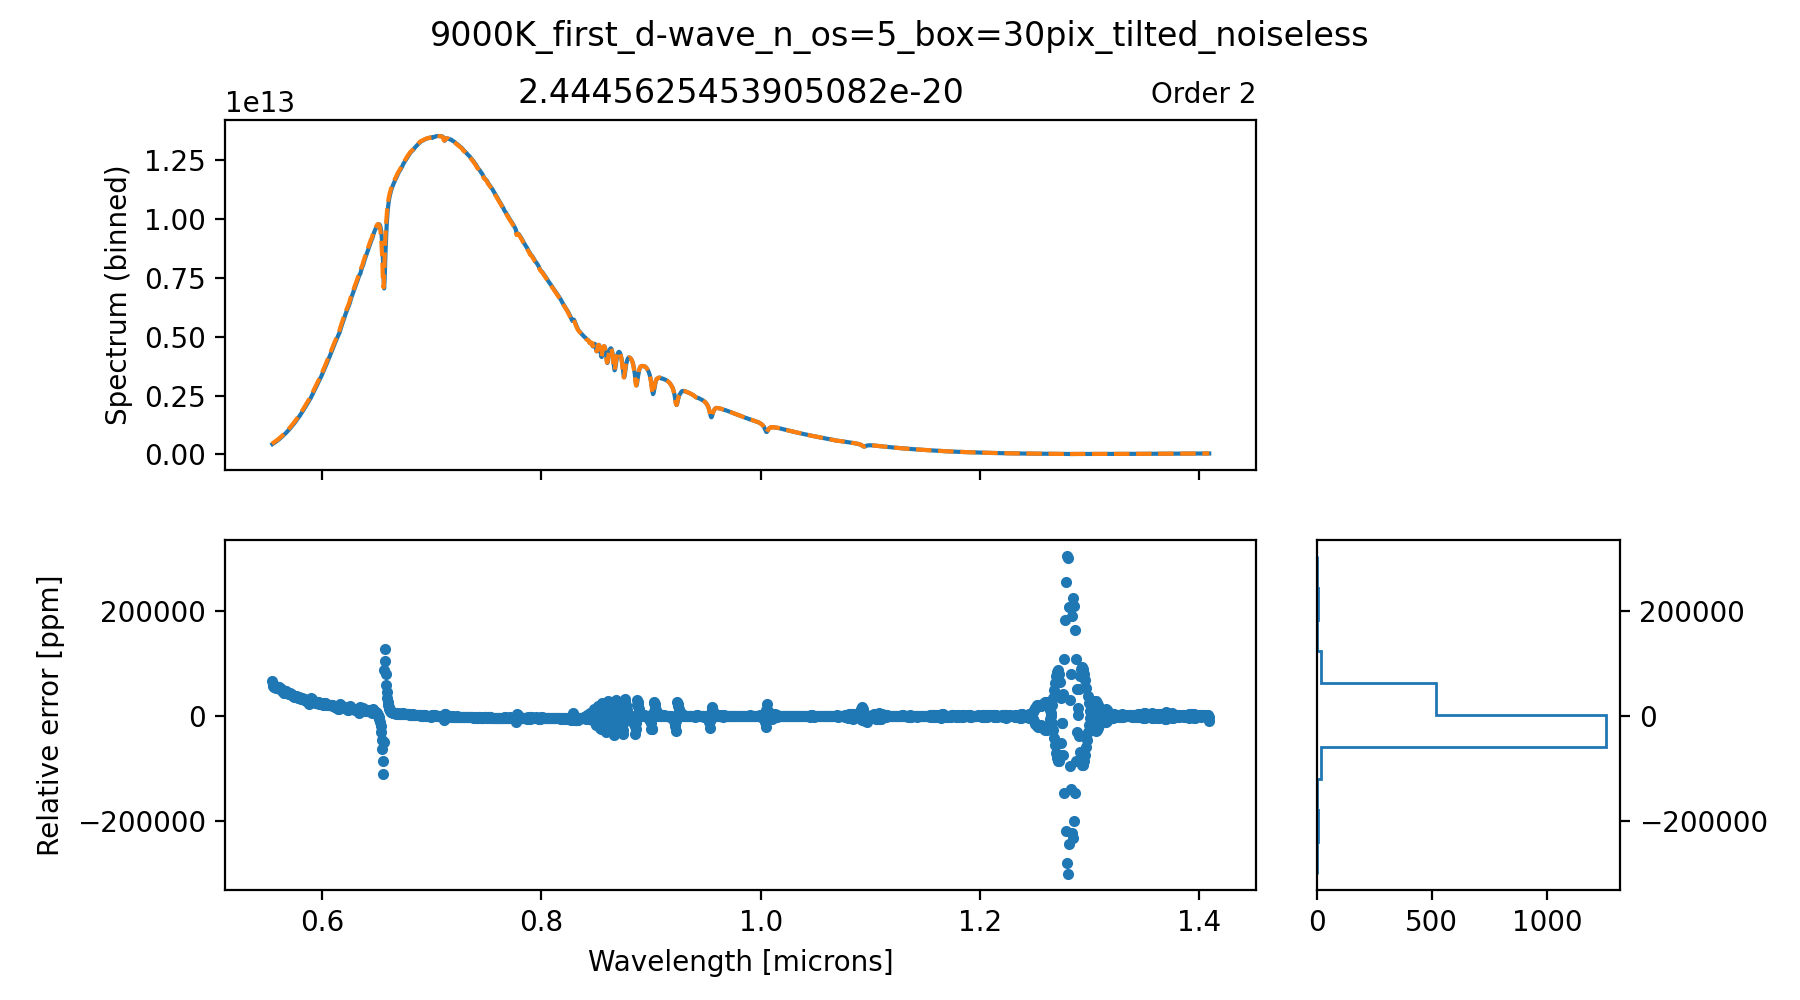

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


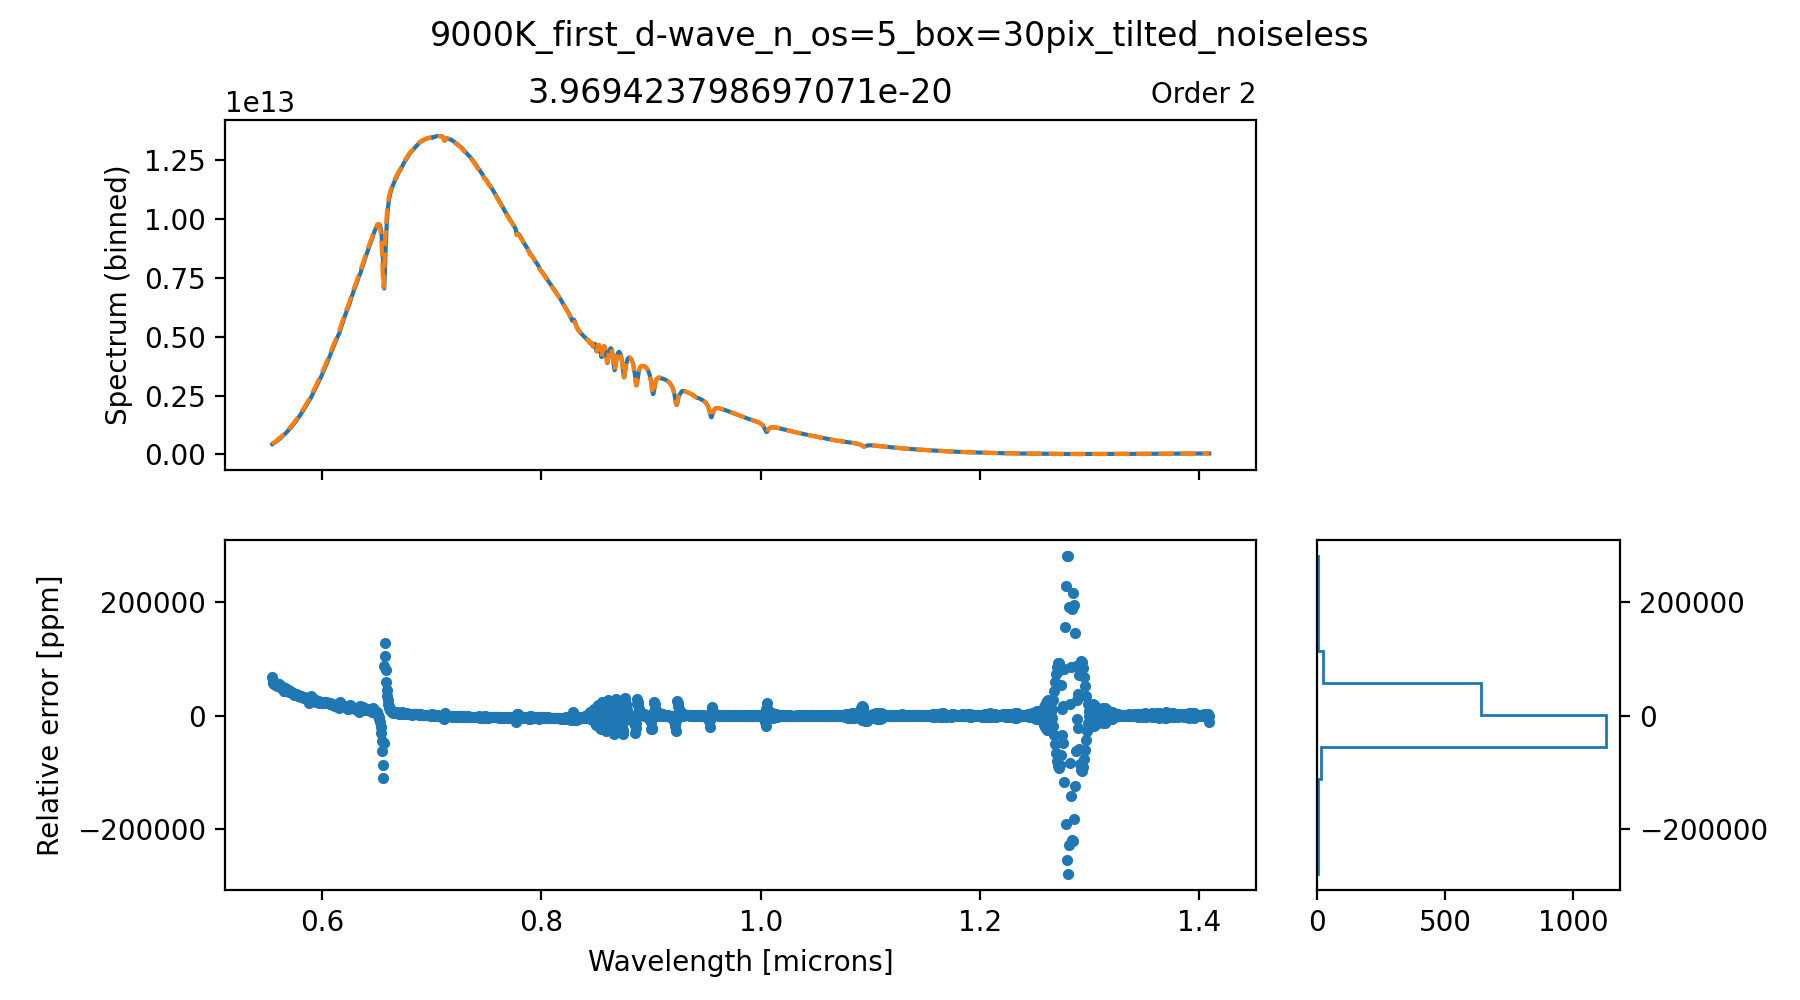

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


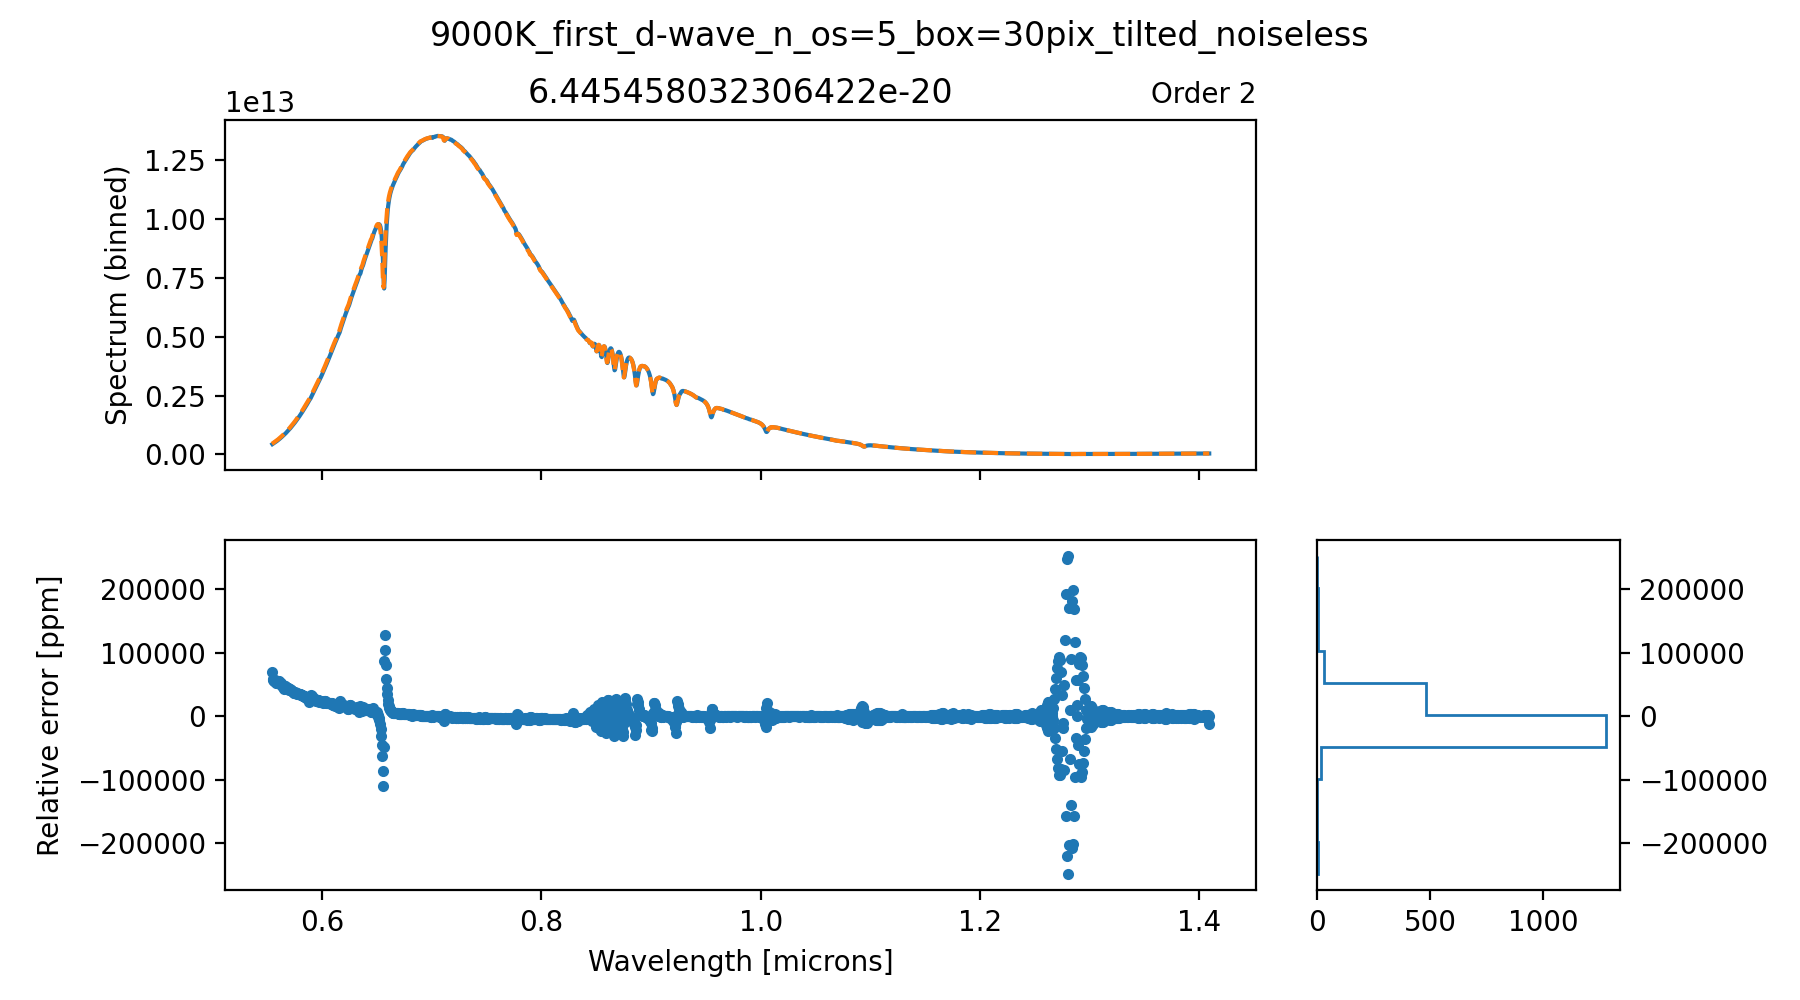

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


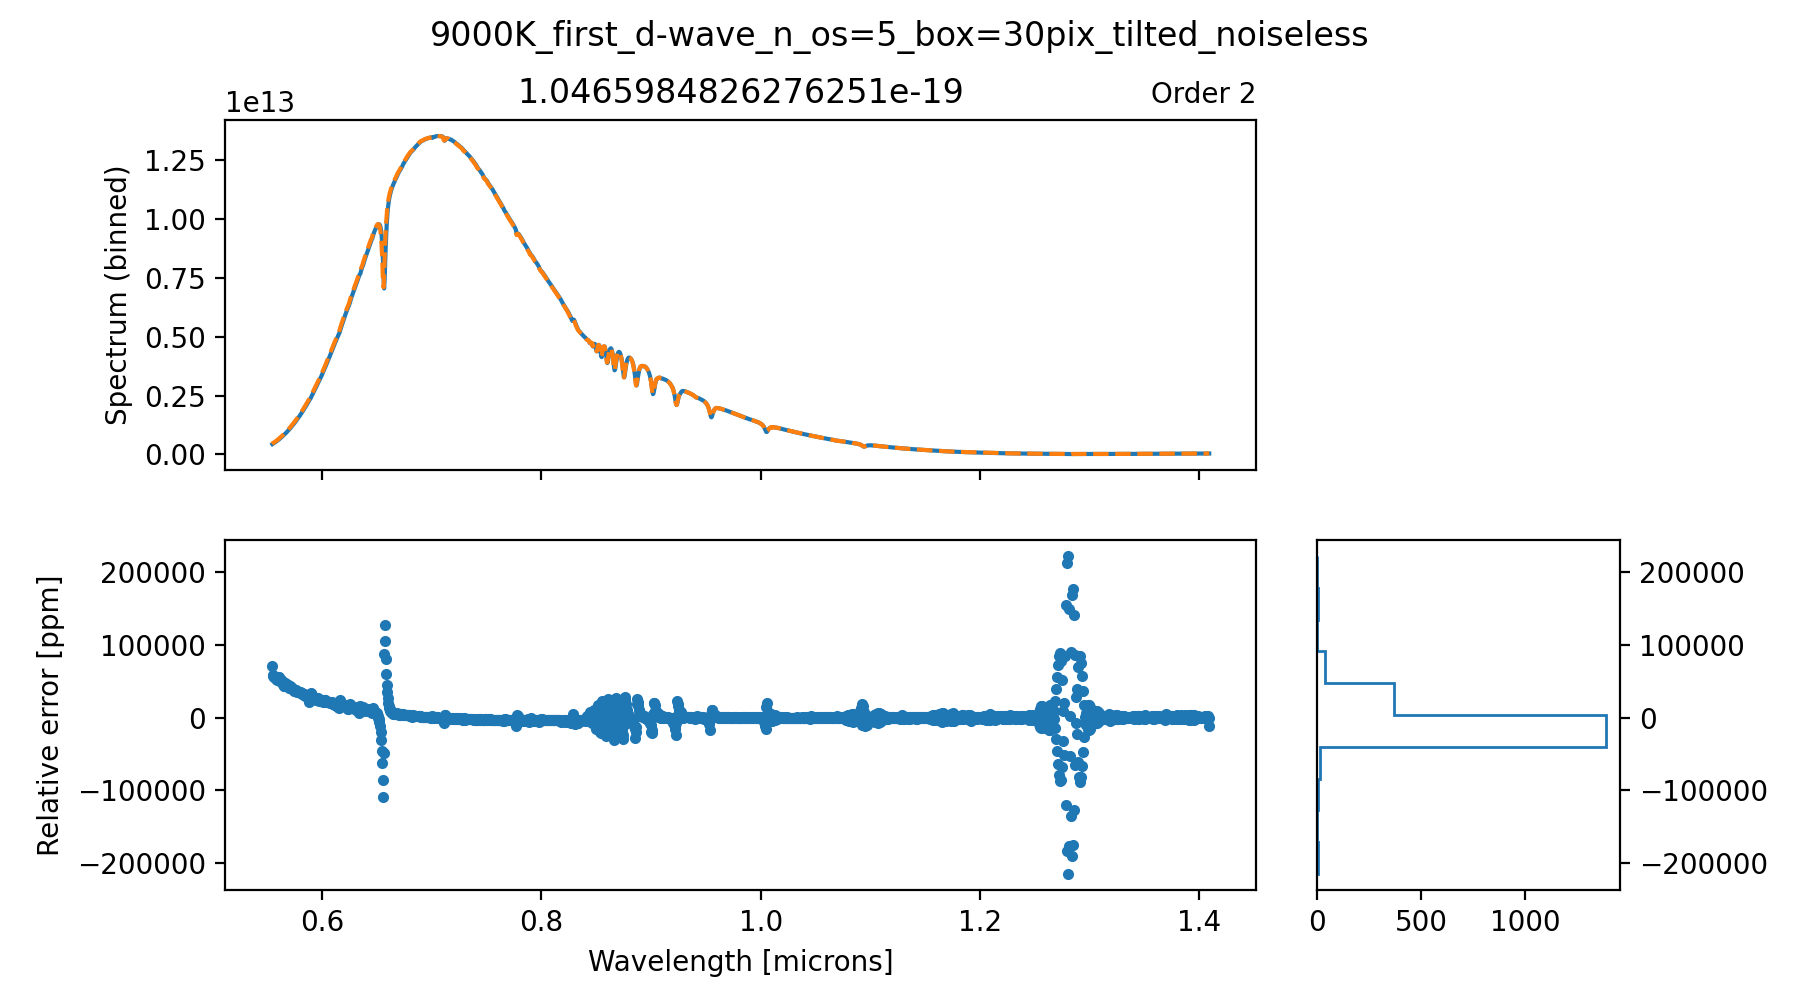

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


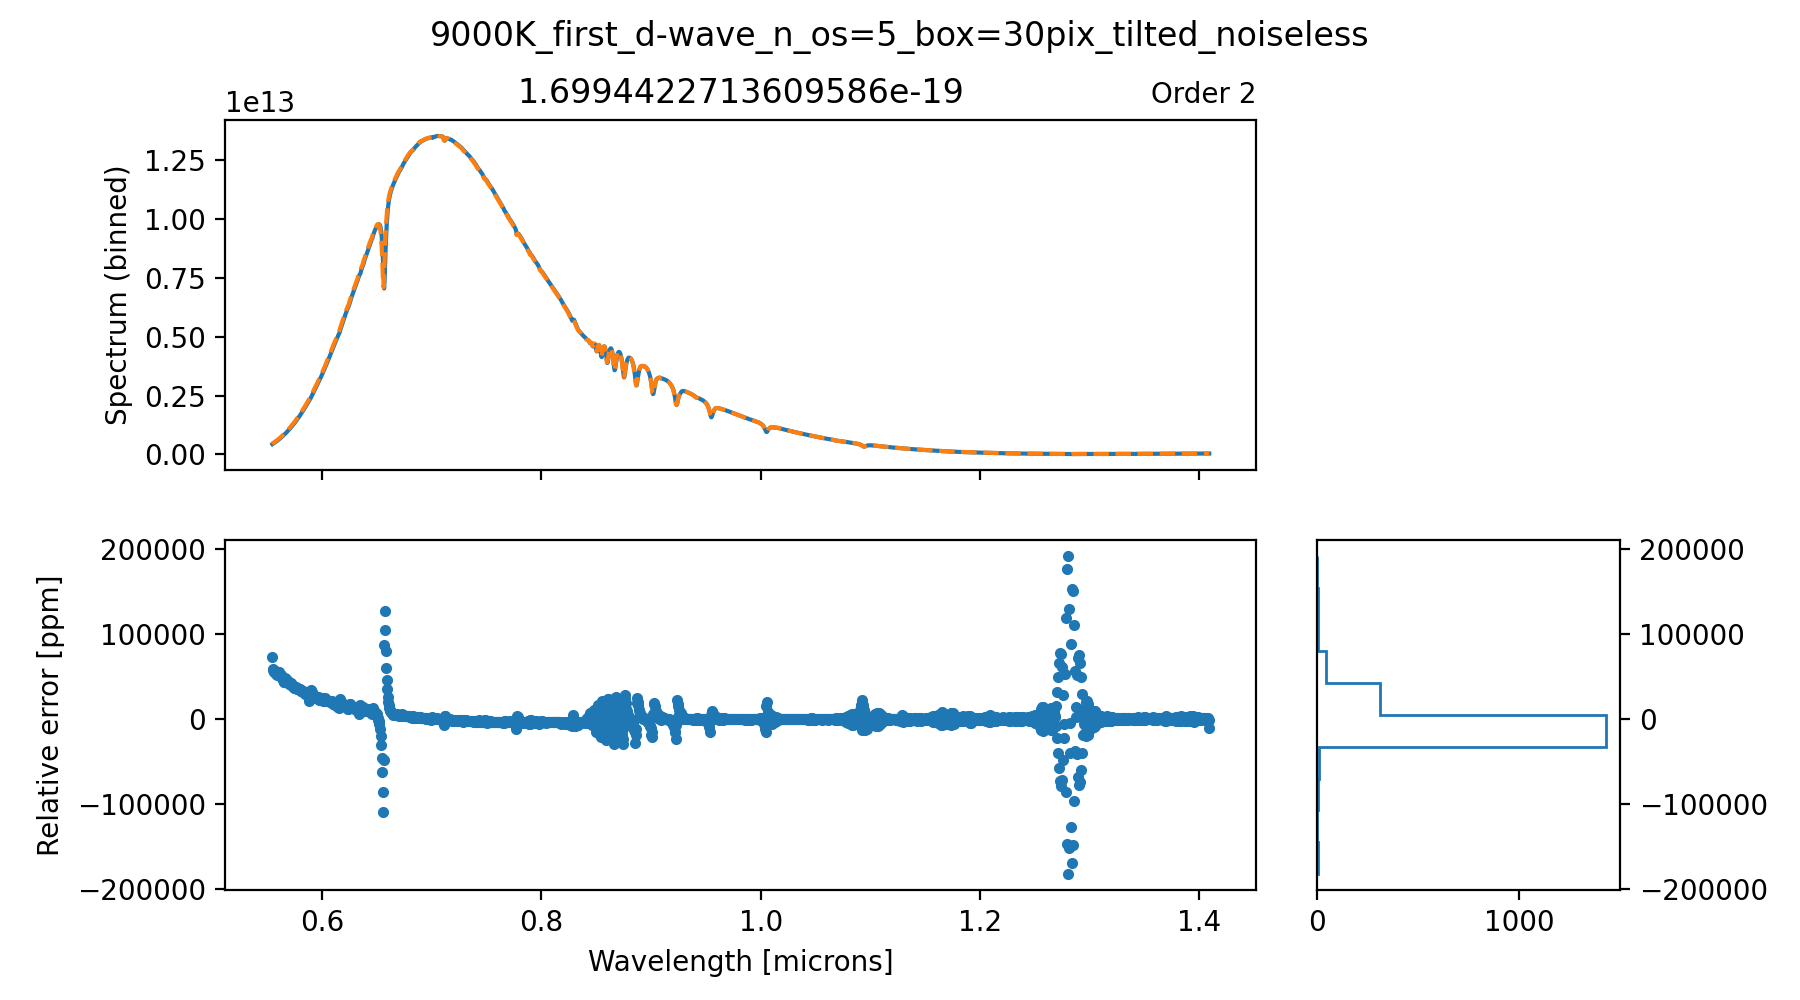

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


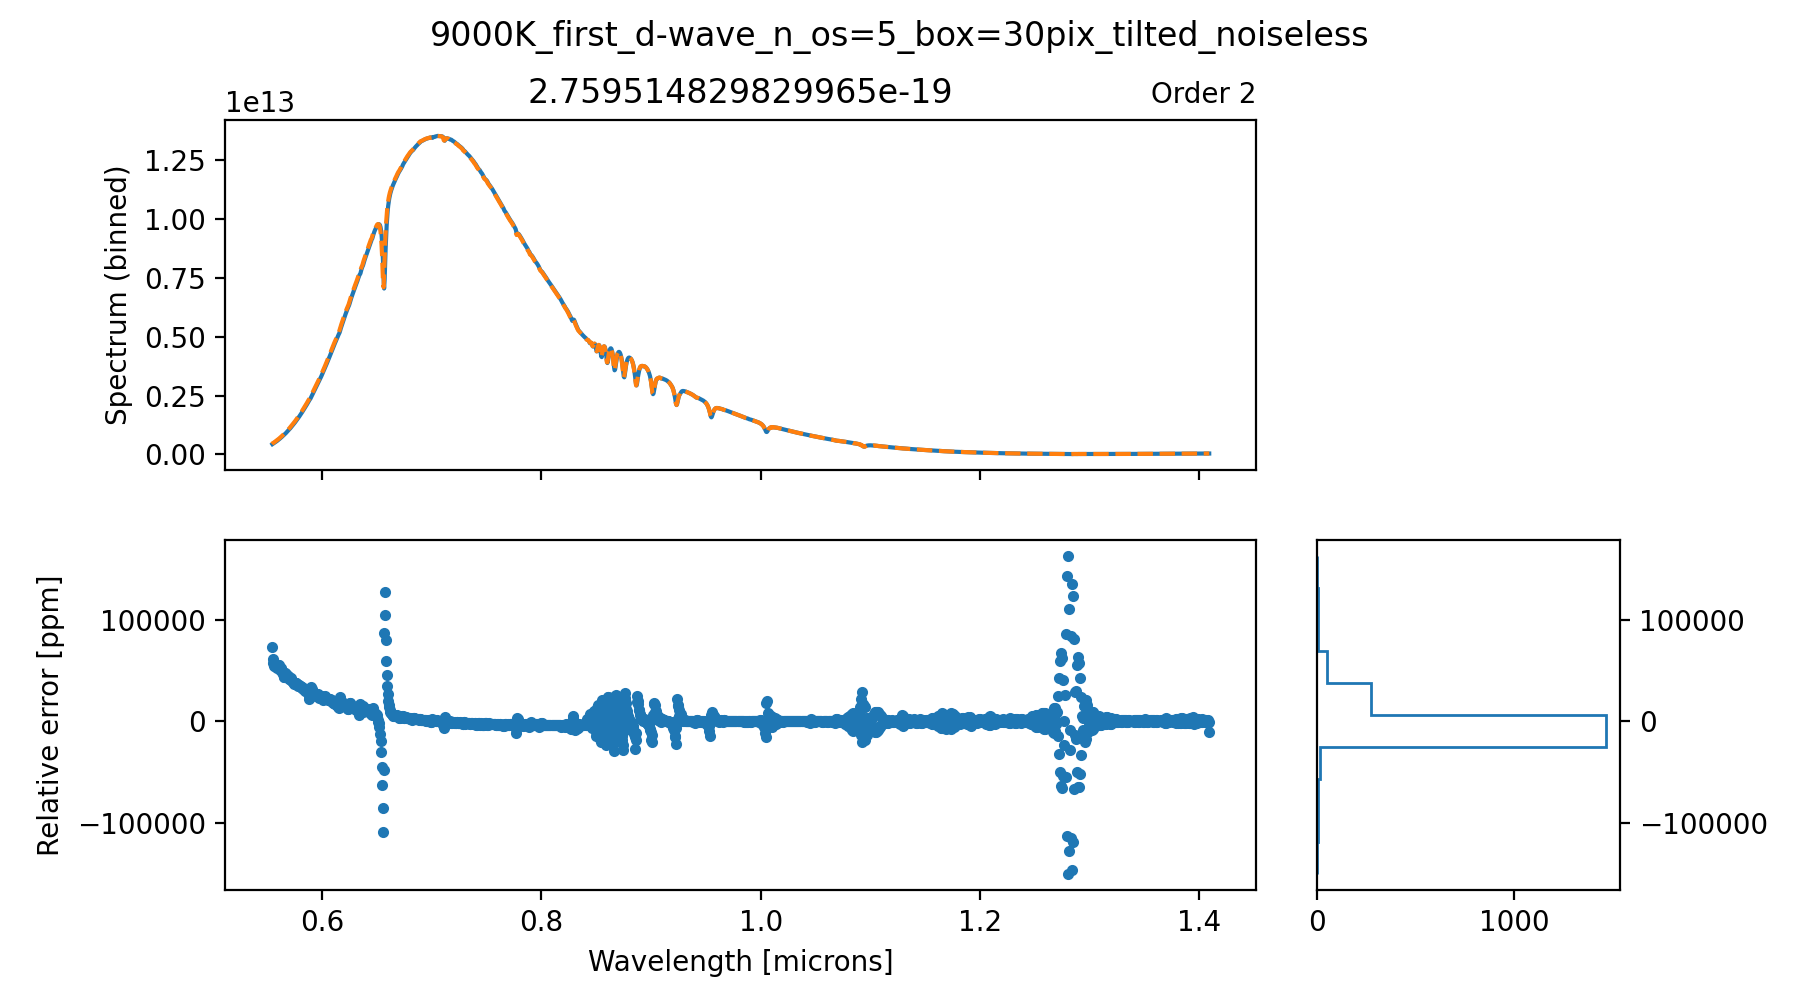

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


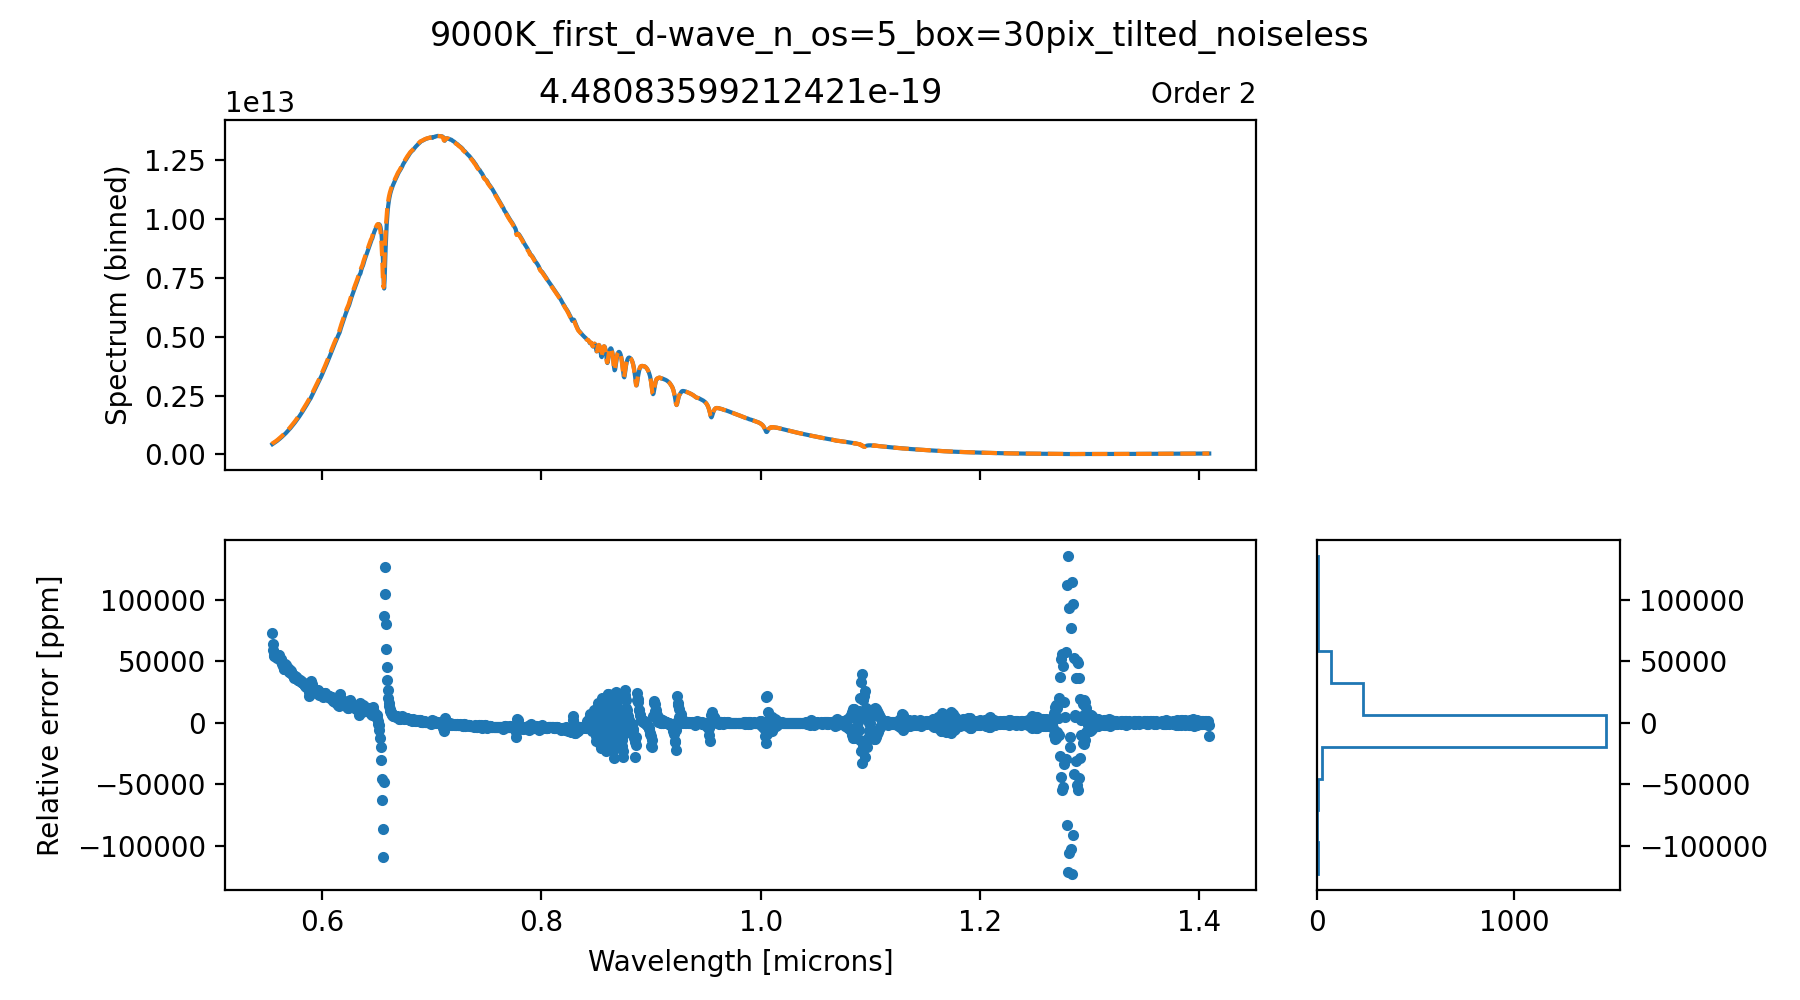

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


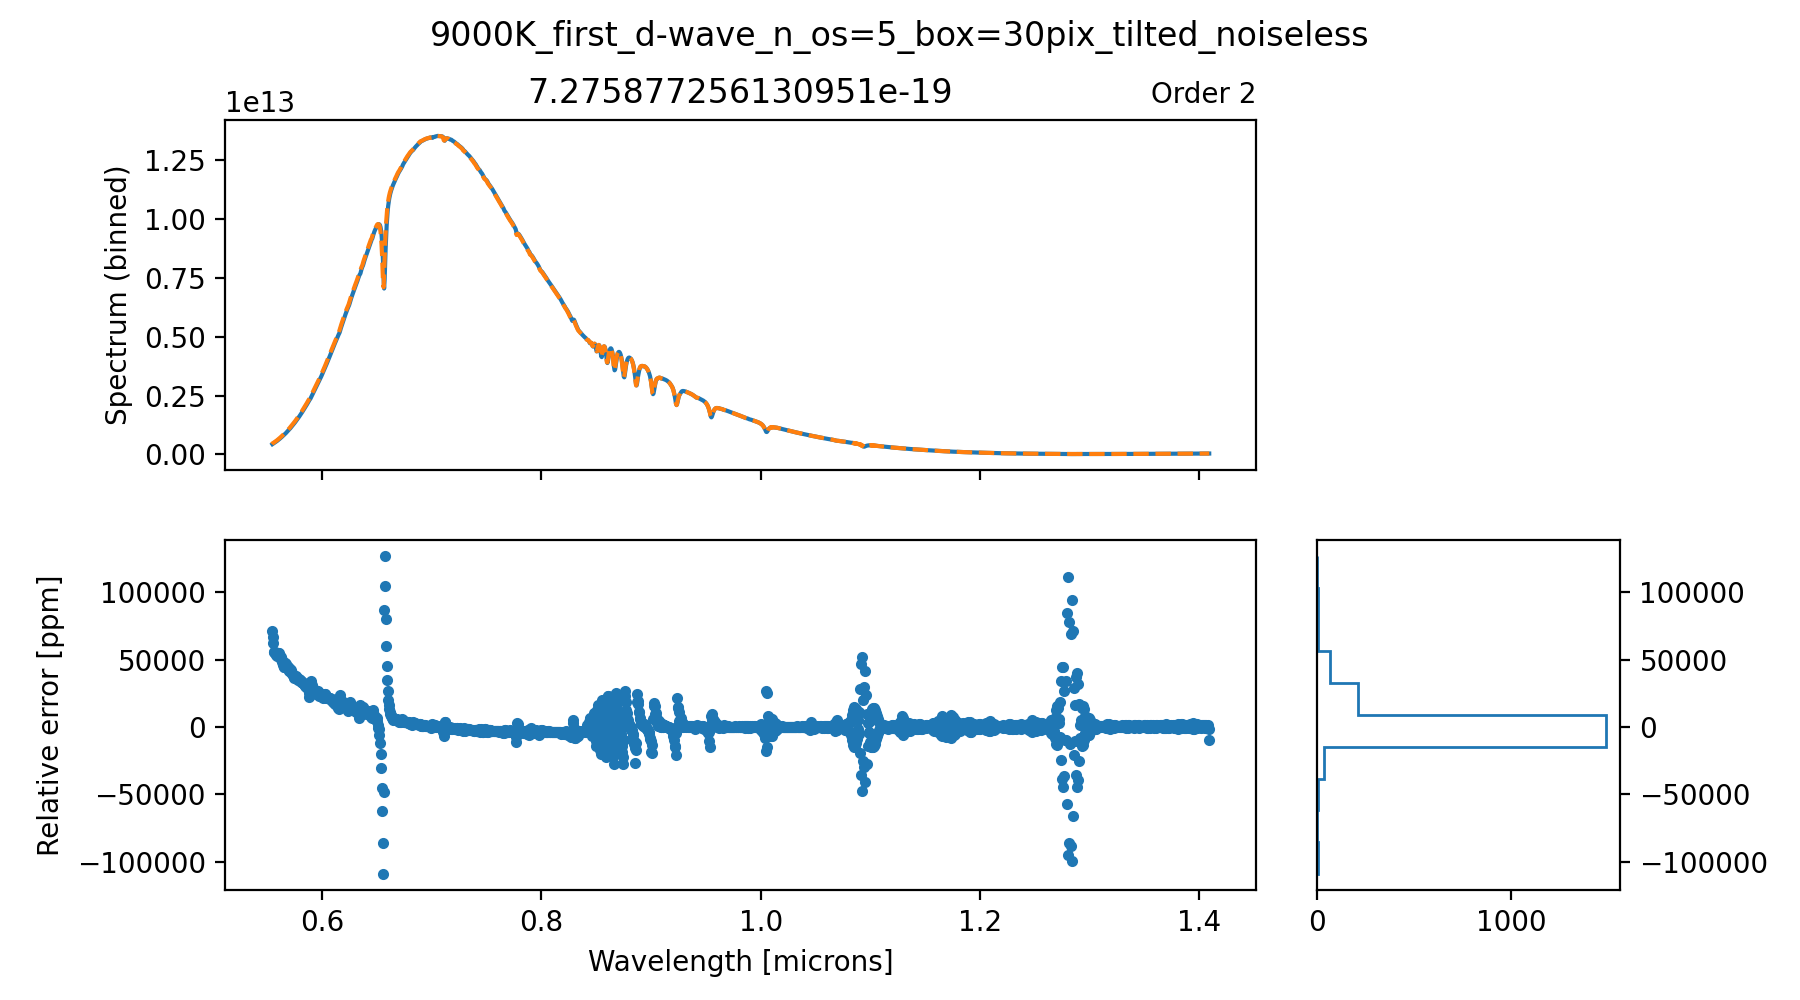

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


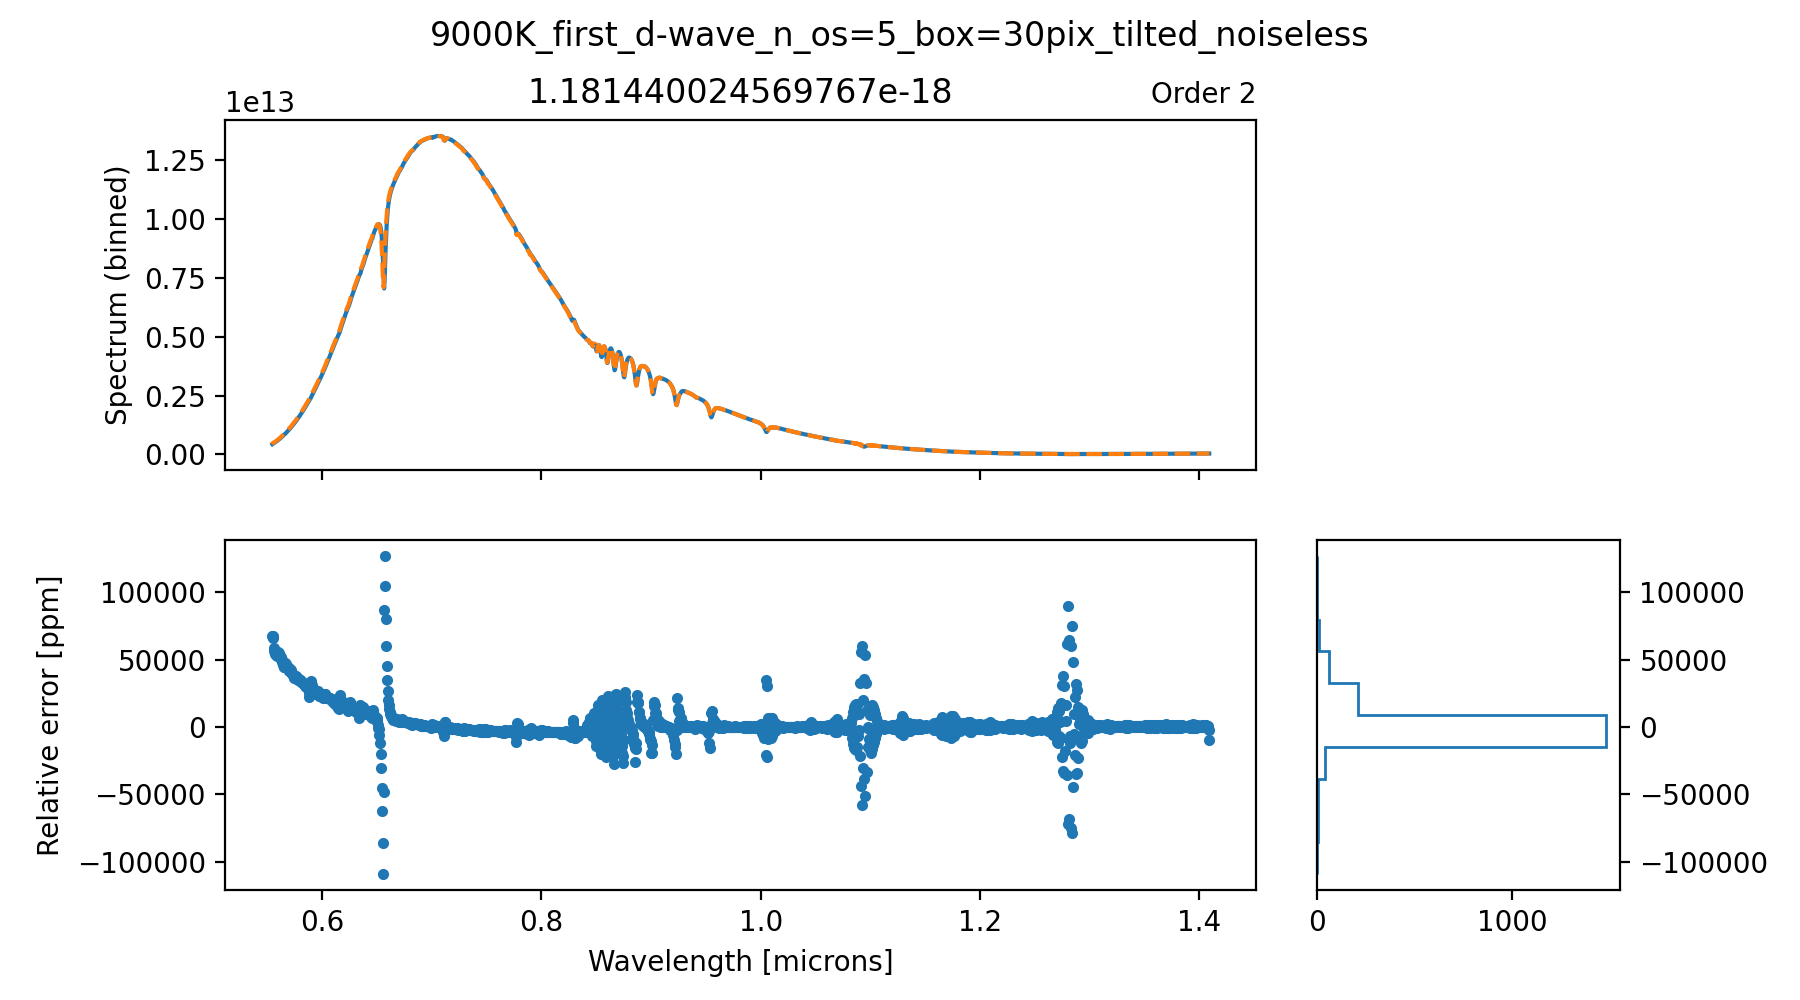

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


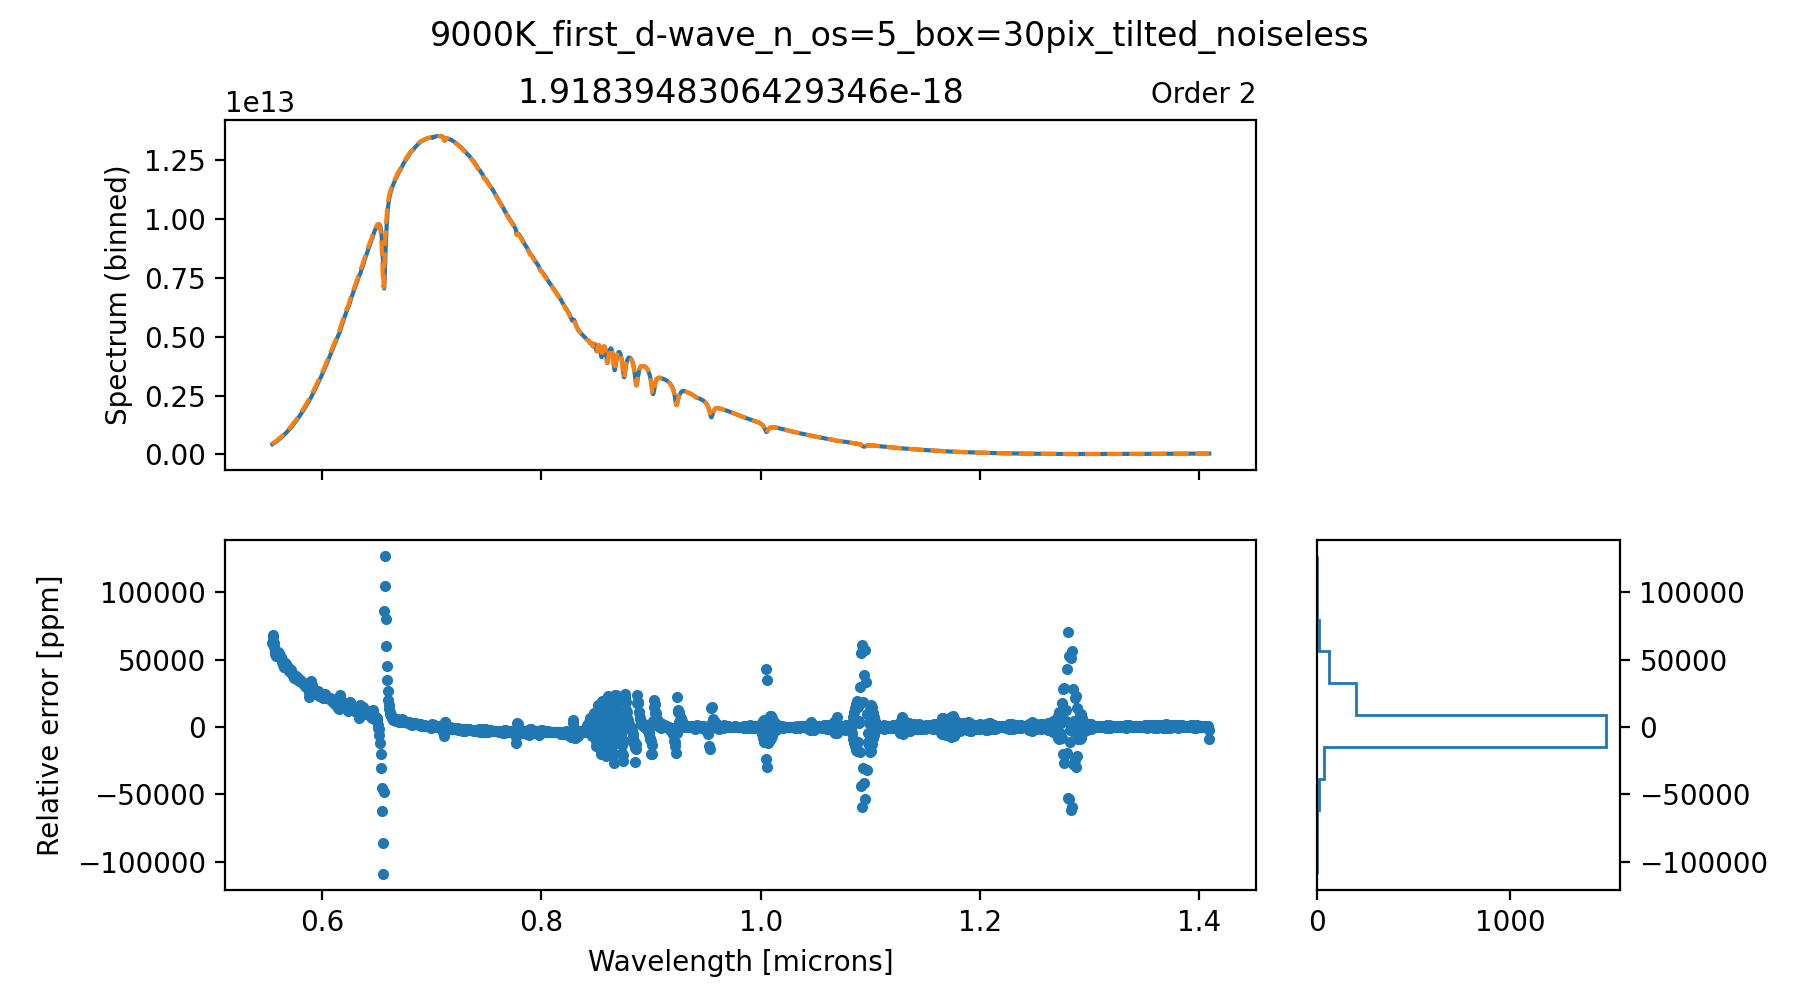

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


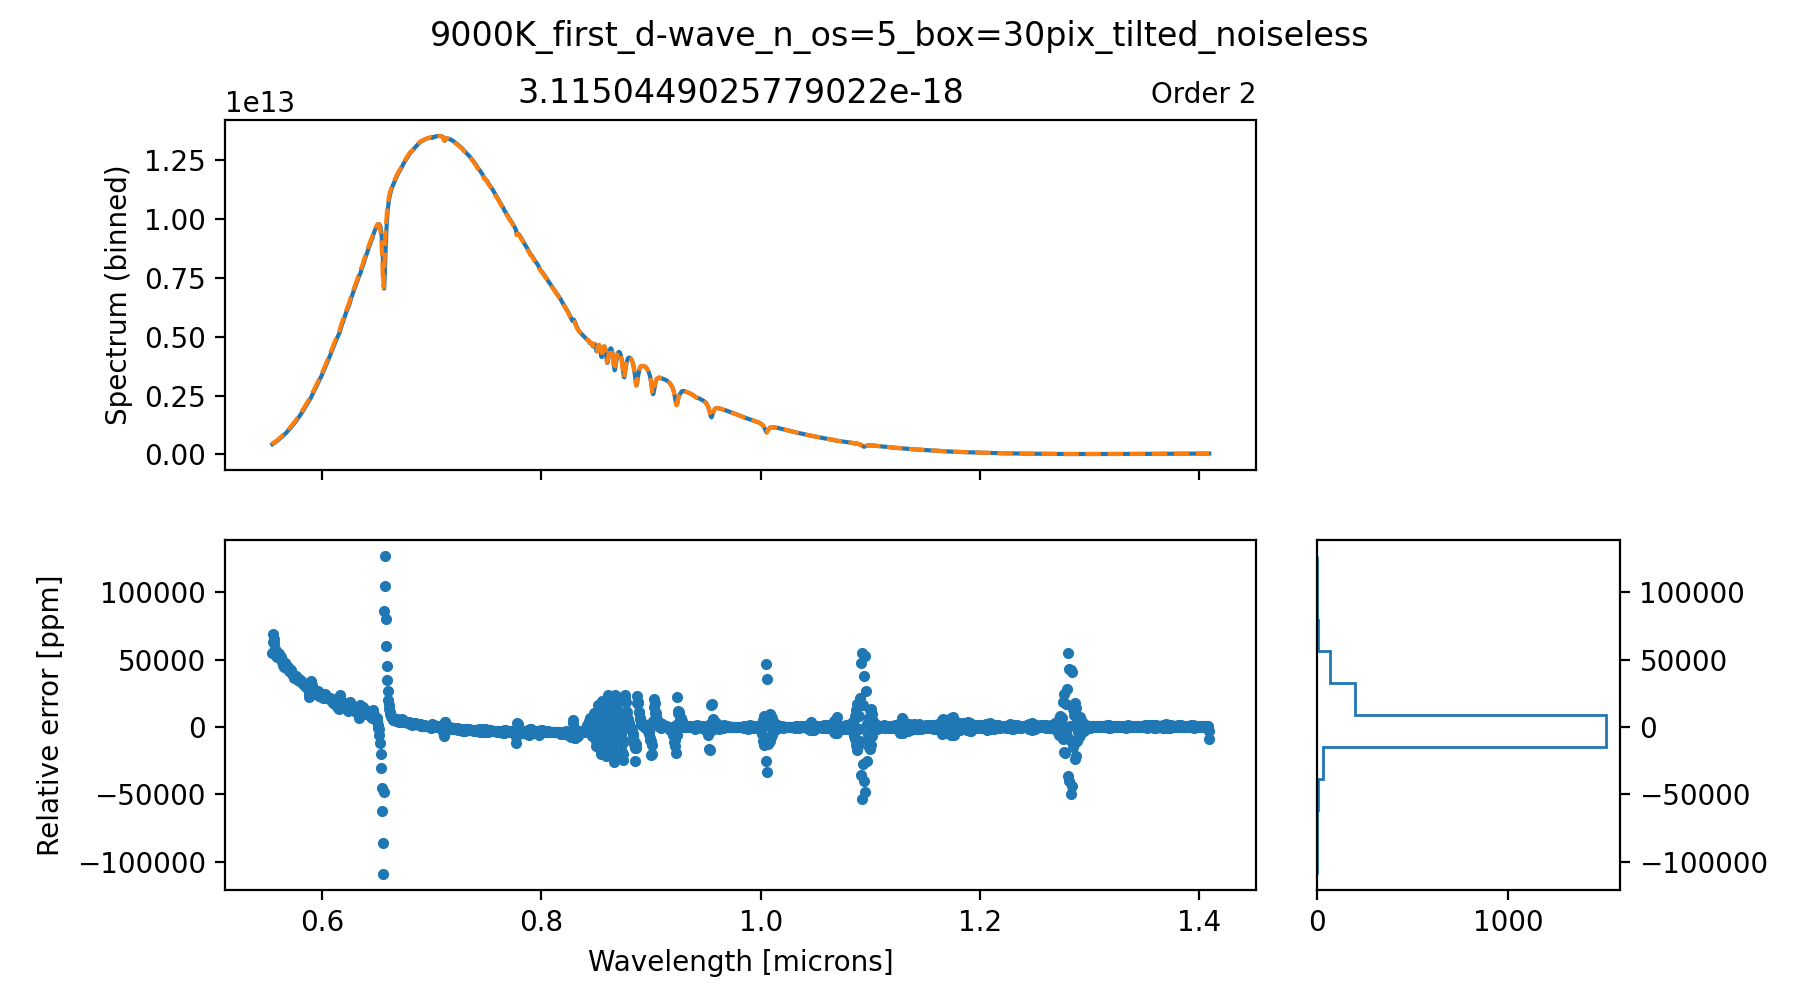

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


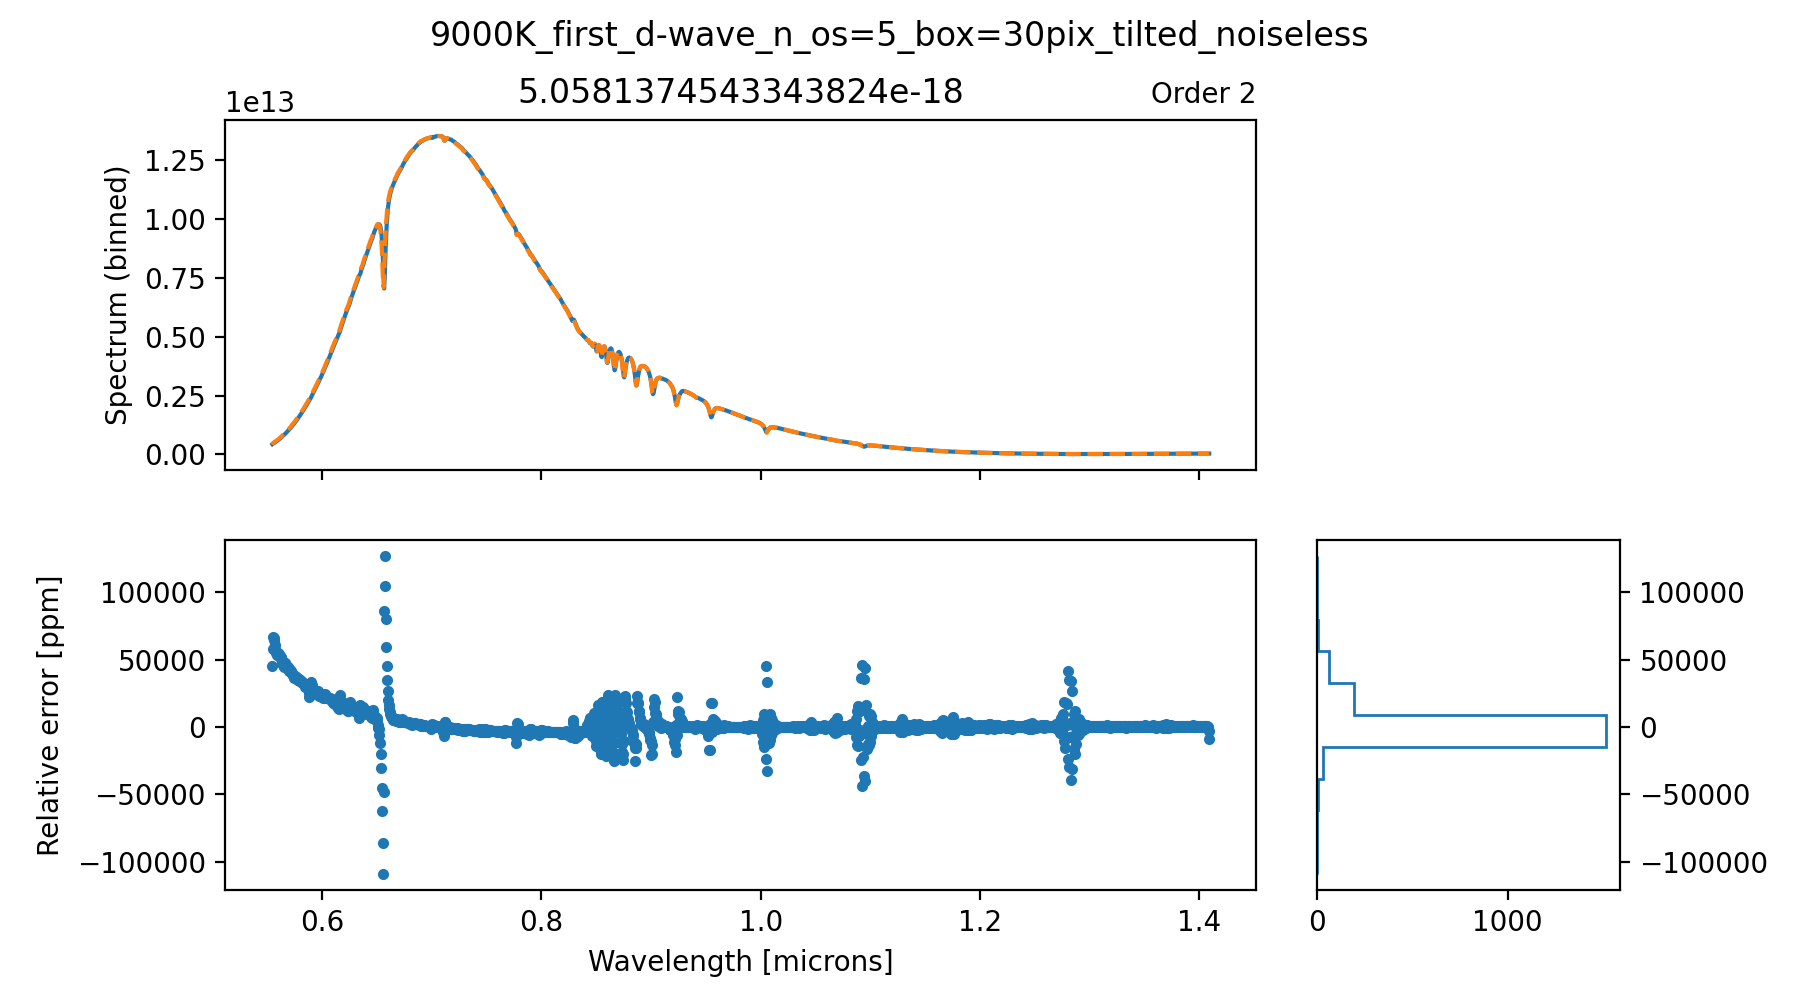

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [483]:

order = 2
for i_sln, fac in enumerate(test_contaminated.tikho_tests_binned[order]['factors']):
    if (fac > 1e-20) & (fac < 1e-17):
        f_bin = test_contaminated.tikho_tests_binned[order]['f_bin'][i_sln]
        fig, ax = test_contaminated.compare_binned_ord(f_bin=f_bin, order=order)#, wv_range=[0.7, 2.5])
        ax[0].set_title(fac)

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


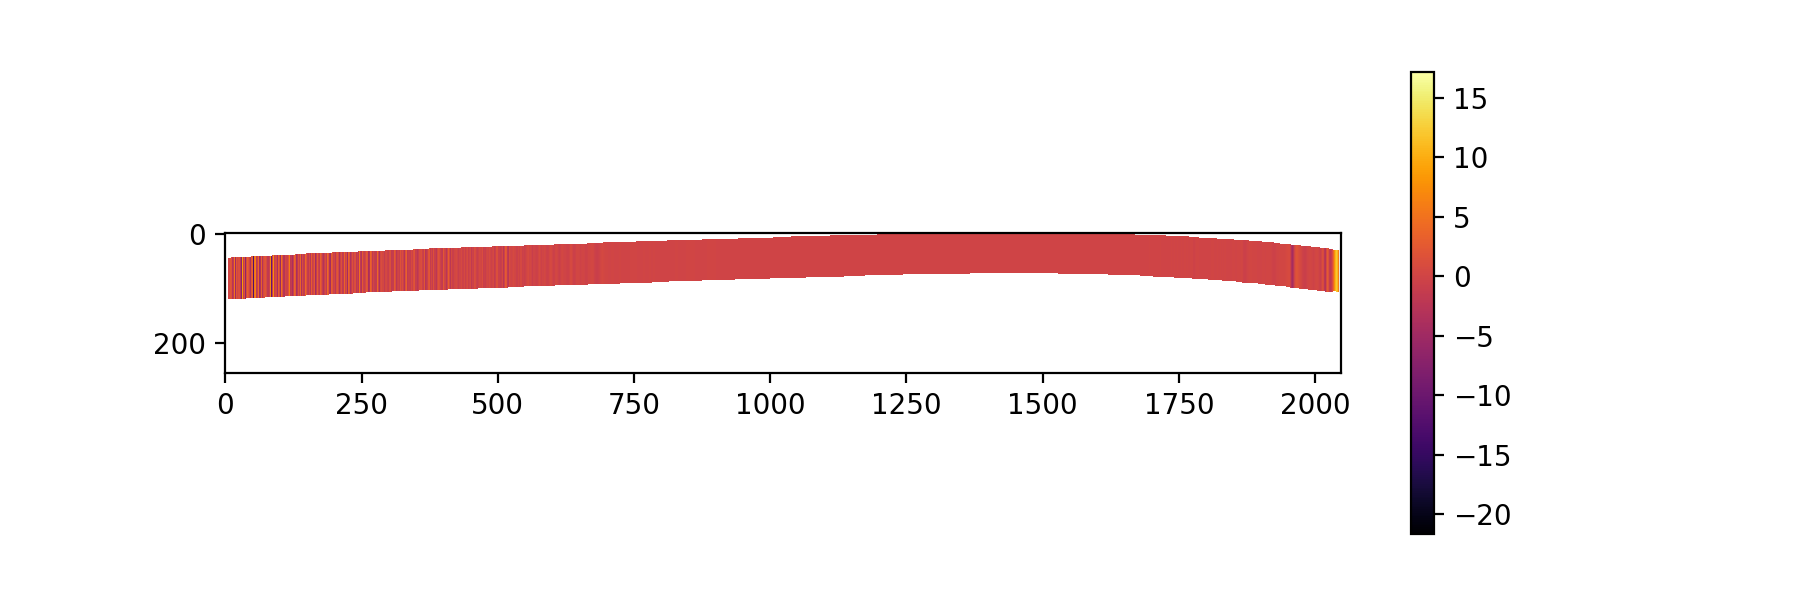

In [141]:
plt.imshow((rebuilt_ord[1]-data_ord[1])/data_ord[1] * 1e6)
plt.colorbar()

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


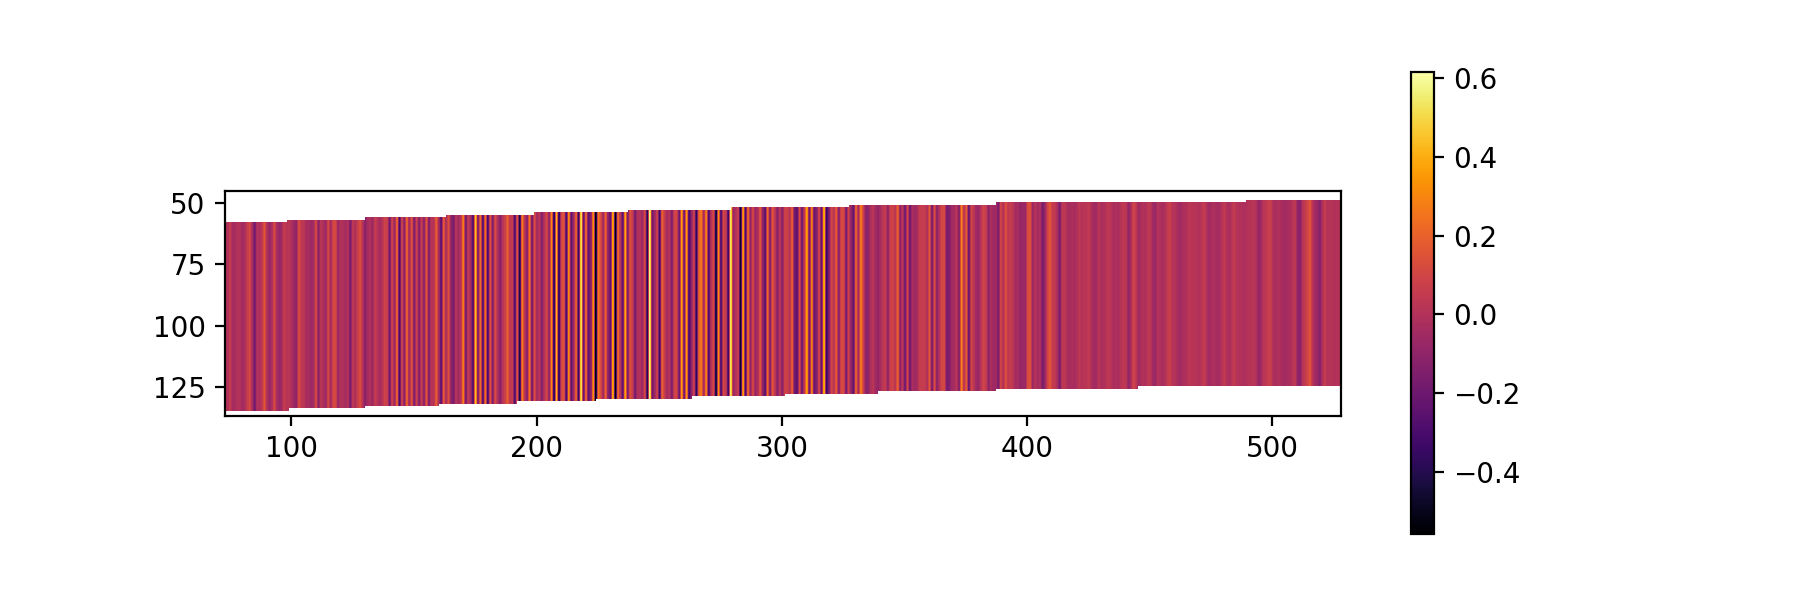

In [154]:
plt.imshow((scidata-rebuilt_ord[2]-data_ord[1])/np.abs(scidata-data_ord[1]) * 1e2)
plt.colorbar()

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


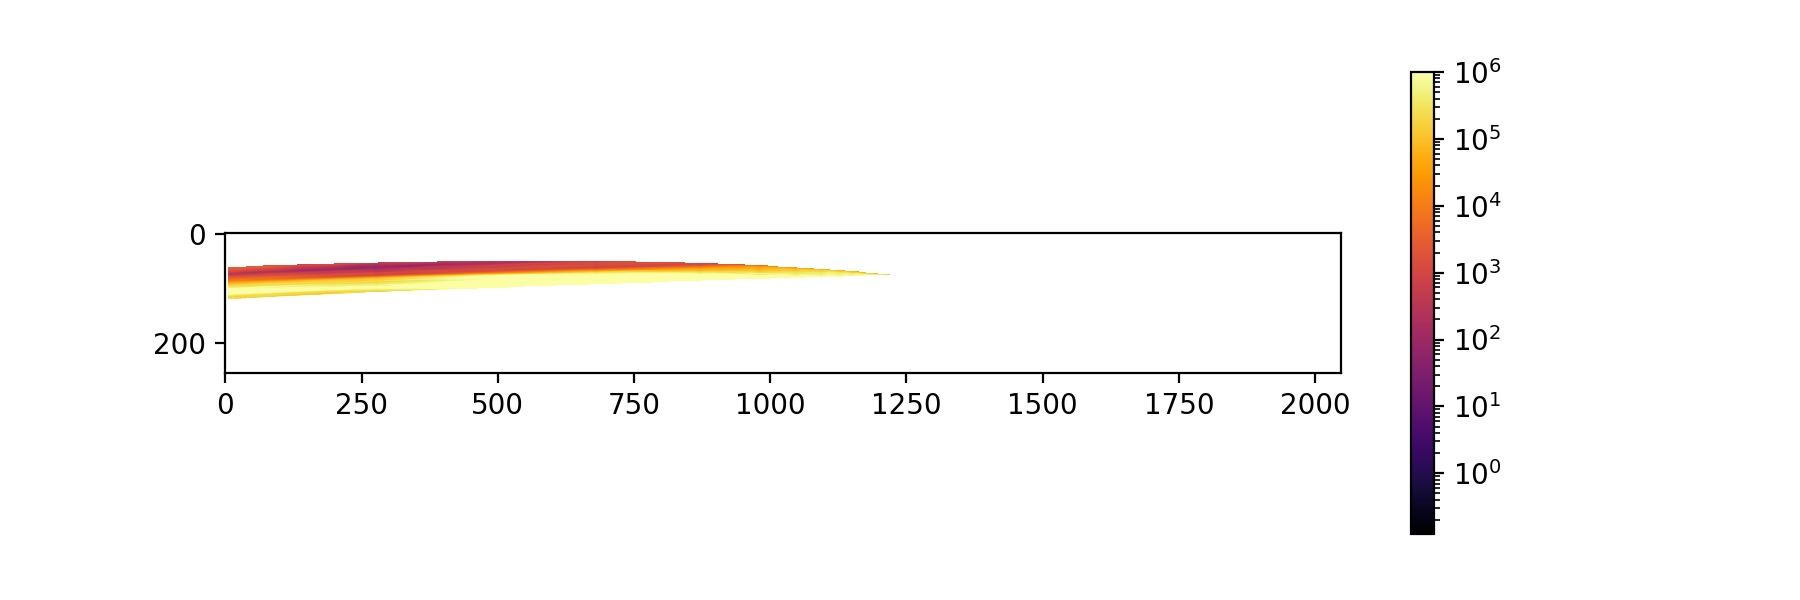

In [150]:
plt.imshow(np.abs(scidata-data_ord[1])/data_ord[1] * 1e6, norm=LogNorm(), vmax=1e6)
plt.colorbar()